<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

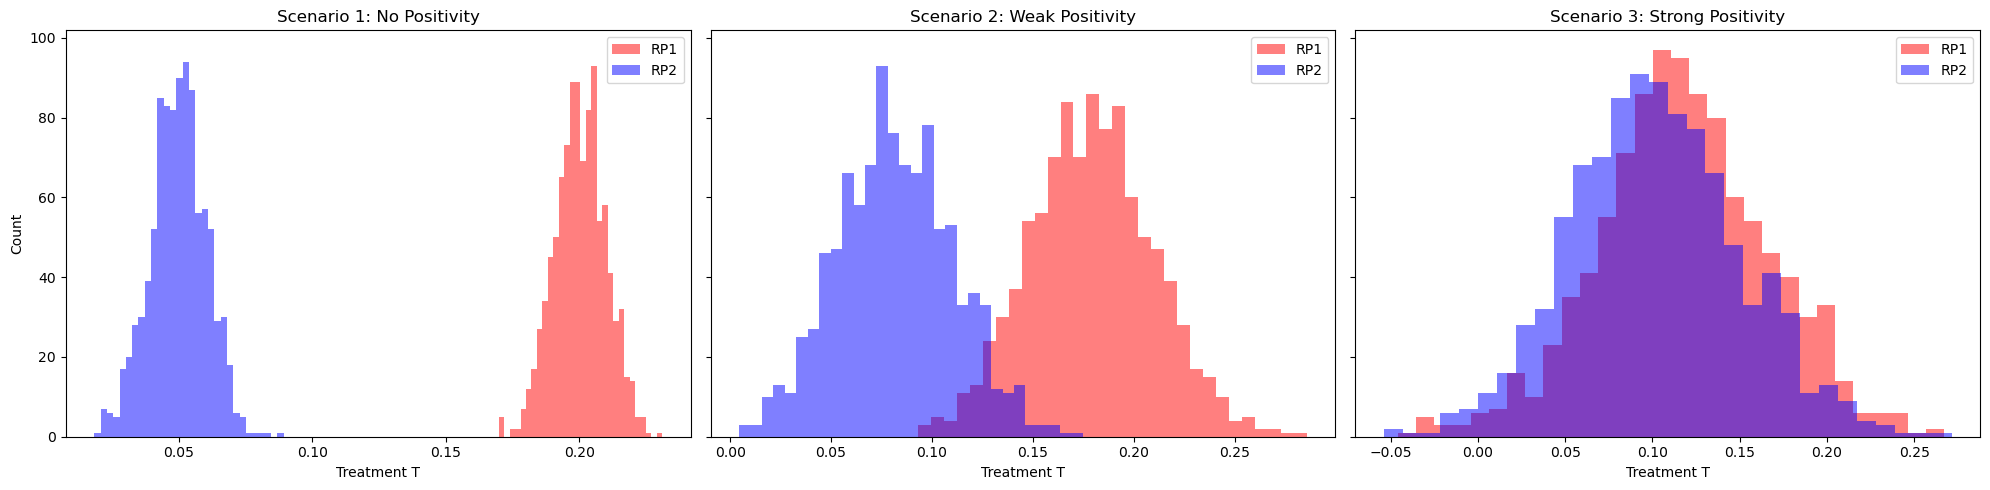

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

N = 2000

def simulate_scenario(means, sds):
    """
    means: dict {'RP1': μ1, 'RP2': μ0}
    sds: dict {'RP1': sd1, 'RP2': sd0}
    """
    X = np.random.choice(['RP1', 'RP2'], size=N)

    T = np.where(
        X == 'RP1',
        np.random.normal(means['RP1'], sds['RP1'], N),
        np.random.normal(means['RP2'], sds['RP2'], N)
    )

    return pd.DataFrame({'X': X, 'T': T})


# --------------------------
# Scenario definitions
# --------------------------

# Scenario 1: No positivity (no overlap)
sc1 = simulate_scenario(
    means={'RP1': 0.20, 'RP2': 0.05},
    sds={'RP1': 0.01, 'RP2': 0.01}
)

# Scenario 2: Weak positivity (small overlap)
sc2 = simulate_scenario(
    means={'RP1': 0.18, 'RP2': 0.08},
    sds={'RP1': 0.03, 'RP2': 0.03}
)

# Scenario 3: Strong positivity (large overlap)
sc3 = simulate_scenario(
    means={'RP1': 0.12, 'RP2': 0.10},
    sds={'RP1': 0.05, 'RP2': 0.05}
)

# --------------------------
# Plotting
# --------------------------

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

scenarios = [(sc1, "Scenario 1: No Positivity"),
             (sc2, "Scenario 2: Weak Positivity"),
             (sc3, "Scenario 3: Strong Positivity")]

for ax, (df, title) in zip(axes, scenarios):
    for group, color in zip(['RP1', 'RP2'], ['red', 'blue']):
        subset = df[df['X'] == group]
        ax.hist(subset['T'], bins=30, alpha=0.5, label=group, color=color)
    
    ax.set_title(title)
    ax.set_xlabel("Treatment T")
    ax.legend()

axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()

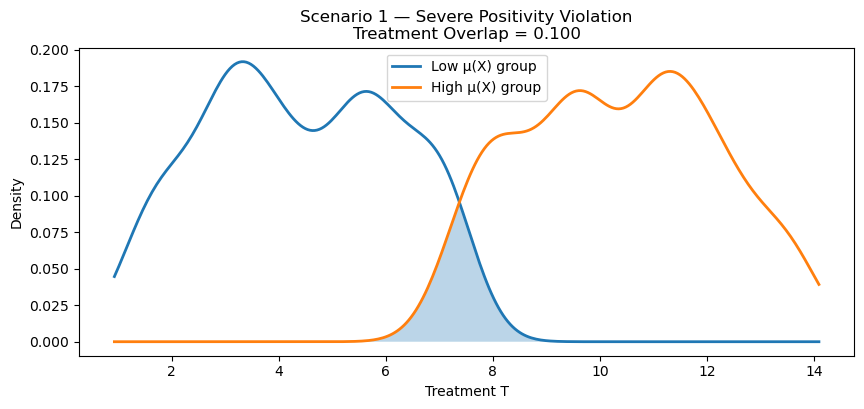

Scenario 1 — Severe Positivity Violation
Overlap Score: 0.0997
❌ Strong positivity violation detected


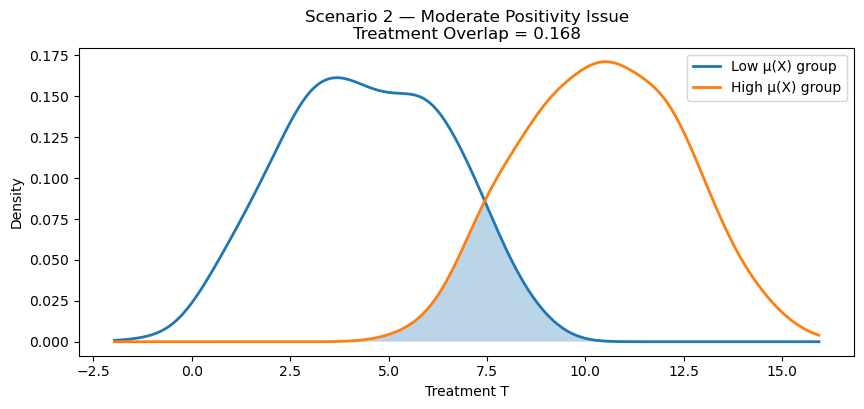

Scenario 2 — Moderate Positivity Issue
Overlap Score: 0.1680
❌ Strong positivity violation detected


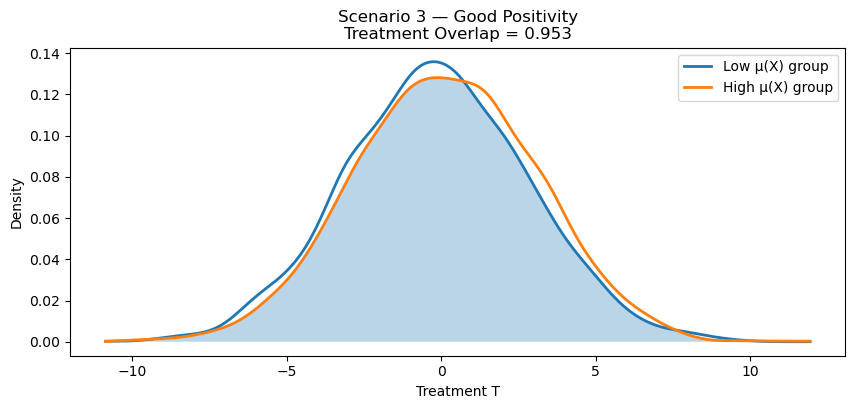

Scenario 3 — Good Positivity
Overlap Score: 0.9527
✅ Good positivity (treatment overlaps across confounders)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KernelDensity


# ============================================================
# 1. SIMULATE MULTI-CONFOUNDER SCENARIOS
# ============================================================

def simulate_scenario(n, scenario):
    """
    scenario:
        1 = severe positivity violation
        2 = moderate violation
        3 = good positivity
    """

    x1 = np.random.choice(["A", "B", "C"], size=n)
    x2 = np.random.choice(["K1", "K2", "K3", "K4"], size=n)
    x3 = np.random.choice(["low", "high"], size=n)

    df = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3})

    # Underlying treatment pattern
    def base_mu(row):
        mu = 0
        if row["x1"] == "A": mu += 1
        if row["x1"] == "B": mu += 5
        if row["x1"] == "C": mu += 9

        if row["x2"] == "K1": mu += 0.5
        if row["x2"] == "K2": mu += 1
        if row["x2"] == "K3": mu += 2
        if row["x2"] == "K4": mu += 3

        if row["x3"] == "low": mu += 0
        if row["x3"] == "high": mu += 1.5

        return mu

    mu_arr = df.apply(base_mu, axis=1).values

    if scenario == 1:
        # Strong violation → almost deterministic T|X
        noise = np.random.normal(0, 0.2, size=n)
        df["T"] = mu_arr + noise
    elif scenario == 2:
        # Moderate violation
        noise = np.random.normal(0, 1.0, size=n)
        df["T"] = mu_arr + noise
    elif scenario == 3:
        # Good positivity → high noise → random T
        noise = np.random.normal(0, 3.0, size=n)
        df["T"] = noise

    #df["T"] = mu_arr + noise
    return df


# ============================================================
# 2. FLEXIBLE T|X MODEL (RANDOM FOREST)
# ============================================================

def flexible_tx(df, confounders, treatment="T"):
    enc = OneHotEncoder(sparse_output=False)
    X = enc.fit_transform(df[confounders])
    T = df[treatment].values

    model = RandomForestRegressor(
        n_estimators=300,
        min_samples_leaf=5,
        random_state=42
    )
    model.fit(X, T)
    mu_hat = model.predict(X)

    return mu_hat, T


# ============================================================
# 3. CORRECT POSITIVITY DIAGNOSTIC (SUPPORT-BASED)
# ============================================================

def treatment_support_overlap(mu_hat, T, quantile_split=0.5, bandwidth=0.6):

    # Split units by predicted T|X mean
    threshold = np.quantile(mu_hat, quantile_split)

    low_group = T[mu_hat < threshold][:, None]
    high_group = T[mu_hat >= threshold][:, None]

    # KDE for treatment distributions
    kde_low = KernelDensity(bandwidth=bandwidth).fit(low_group)
    kde_high = KernelDensity(bandwidth=bandwidth).fit(high_group)

    grid = np.linspace(T.min(), T.max(), 300)[:, None]
    low_d = np.exp(kde_low.score_samples(grid))
    high_d = np.exp(kde_high.score_samples(grid))

    # Integral of the minimum density
    overlap = np.trapz(np.minimum(low_d, high_d), grid.squeeze())

    return overlap, grid.squeeze(), low_d, high_d, threshold


# ============================================================
# 4. VISUALIZATION
# ============================================================

def plot_overlap(grid, low_d, high_d, overlap, title):
    plt.figure(figsize=(10, 4))
    plt.plot(grid, low_d, label="Low μ(X) group", lw=2)
    plt.plot(grid, high_d, label="High μ(X) group", lw=2)
    plt.fill_between(grid, np.minimum(low_d, high_d), alpha=0.3)
    plt.title(f"{title}\nTreatment Overlap = {overlap:.3f}")
    plt.xlabel("Treatment T")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


# ============================================================
# 5. RUN THE FULL PIPELINE FOR 3 SCENARIOS
# ============================================================

for scenario in [1, 2, 3]:
    df = simulate_scenario(6000, scenario)

    # Flexible RF model
    mu_hat, T = flexible_tx(df, confounders=["x1", "x2", "x3"])

    # Correct overlap metric
    overlap, grid, low_d, high_d, th = treatment_support_overlap(mu_hat, T)

    title = {
        1: "Scenario 1 — Severe Positivity Violation",
        2: "Scenario 2 — Moderate Positivity Issue",
        3: "Scenario 3 — Good Positivity"
    }[scenario]

    plot_overlap(grid, low_d, high_d, overlap, title)

    print("=" * 80)
    print(title)
    print(f"Overlap Score: {overlap:.4f}")

    if overlap < 0.2:
        print("❌ Strong positivity violation detected")
    elif overlap < 0.5:
        print("⚠️ Moderate positivity issues")
    else:
        print("✅ Good positivity (treatment overlaps across confounders)")
    print("=" * 80)


In [27]:
df = simulate_scenario(3000, 3, seed=42)

In [28]:
# Flexible RF model
mu_hat, T = flexible_tx(df, confounders=["x1", "x2", "x3"])

# Correct overlap metric
overlap, grid, low_d, high_d, th = treatment_support_overlap(mu_hat, T)

In [29]:
overlap

0.6255173691486953

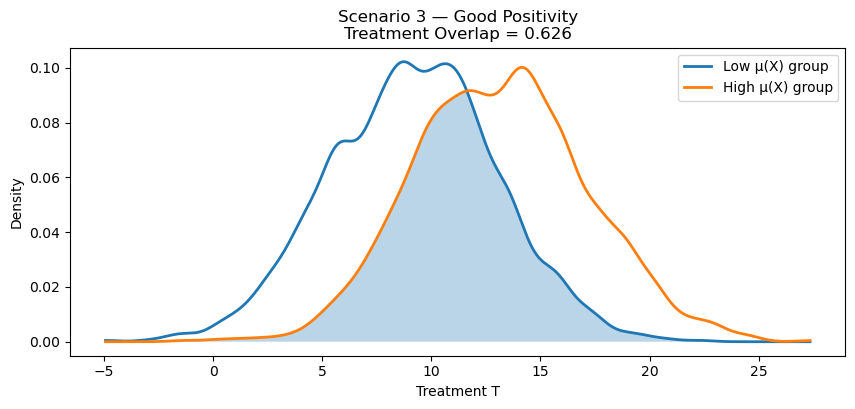

In [30]:
plot_overlap(grid, low_d, high_d, overlap, title)


SCENARIO 1: Severe Positivity Violation
COMPREHENSIVE POSITIVITY DIAGNOSTICS REPORT

1. STRATUM-SPECIFIC POSITIVITY CHECK
----------------------------------------
Total strata analyzed: 24
Strata with violations: 24

Problematic strata:
           strata  n_units  coverage    min_density
0   (A, K1, high)      160      0.15   0.000000e+00
1    (A, K1, low)      242      0.13   0.000000e+00
2   (A, K2, high)      140      0.12   0.000000e+00
3    (A, K2, low)      224      0.08   0.000000e+00
4   (A, K3, high)      176      0.18   0.000000e+00
5    (A, K3, low)      233      0.06   0.000000e+00
6   (A, K4, high)      142      0.16   0.000000e+00
7    (A, K4, low)      214      0.06   0.000000e+00
8   (B, K1, high)      211      0.15   0.000000e+00
9    (B, K1, low)      279      0.17   0.000000e+00
10  (B, K2, high)      197      0.19  9.175872e-154
11   (B, K2, low)      366      0.17   0.000000e+00
12  (B, K3, high)      178      0.15   0.000000e+00
13   (B, K3, low)      285      0.

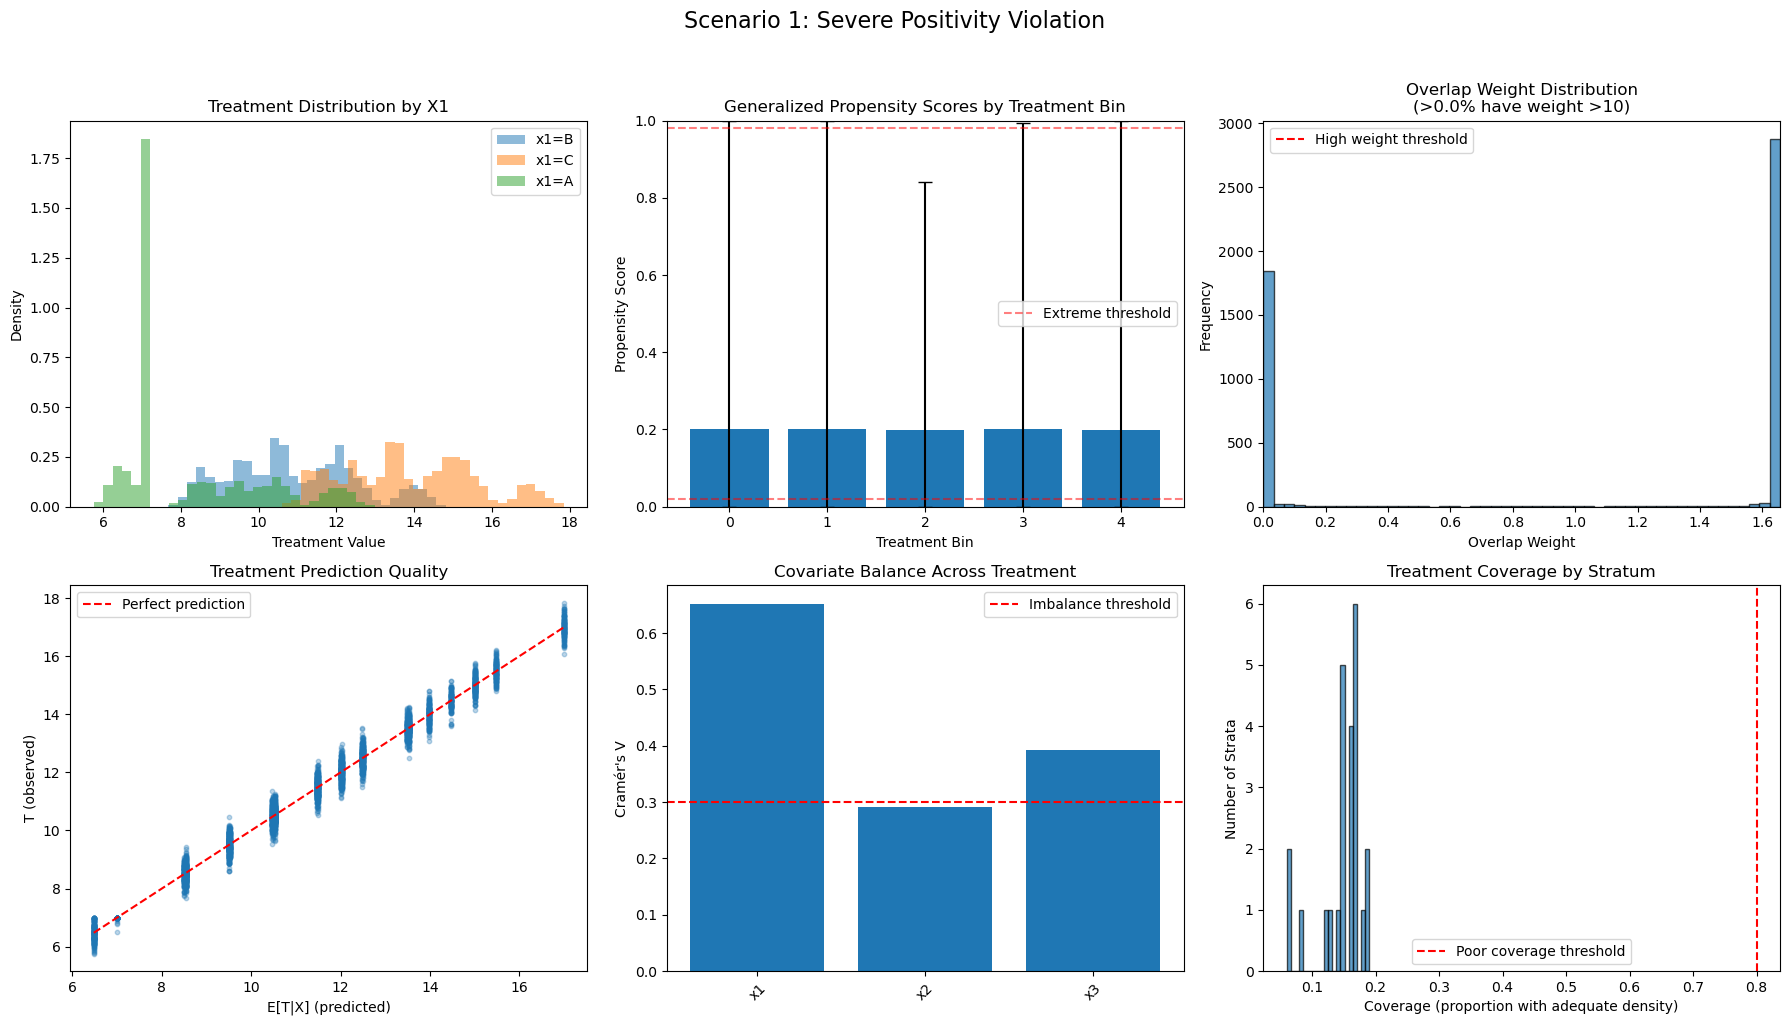


--------------------------------------------------------------------------------
Press Enter to continue to next scenario...

SCENARIO 2: Moderate Positivity Issues
COMPREHENSIVE POSITIVITY DIAGNOSTICS REPORT

1. STRATUM-SPECIFIC POSITIVITY CHECK
----------------------------------------
Total strata analyzed: 24
Strata with violations: 24

Problematic strata:
           strata  n_units  coverage   min_density
0   (A, K1, high)      160      0.40  1.115960e-71
1    (A, K1, low)      242      0.42  3.069692e-88
2   (A, K2, high)      140      0.36  6.251613e-55
3    (A, K2, low)      224      0.46  7.049597e-38
4   (A, K3, high)      176      0.45  2.077862e-14
5    (A, K3, low)      233      0.45  5.257433e-29
6   (A, K4, high)      142      0.45  2.671492e-21
7    (A, K4, low)      214      0.42  5.032760e-44
8   (B, K1, high)      211      0.42  9.842568e-67
9    (B, K1, low)      279      0.41  1.137218e-50
10  (B, K2, high)      197      0.48  4.370744e-11
11   (B, K2, low)      36

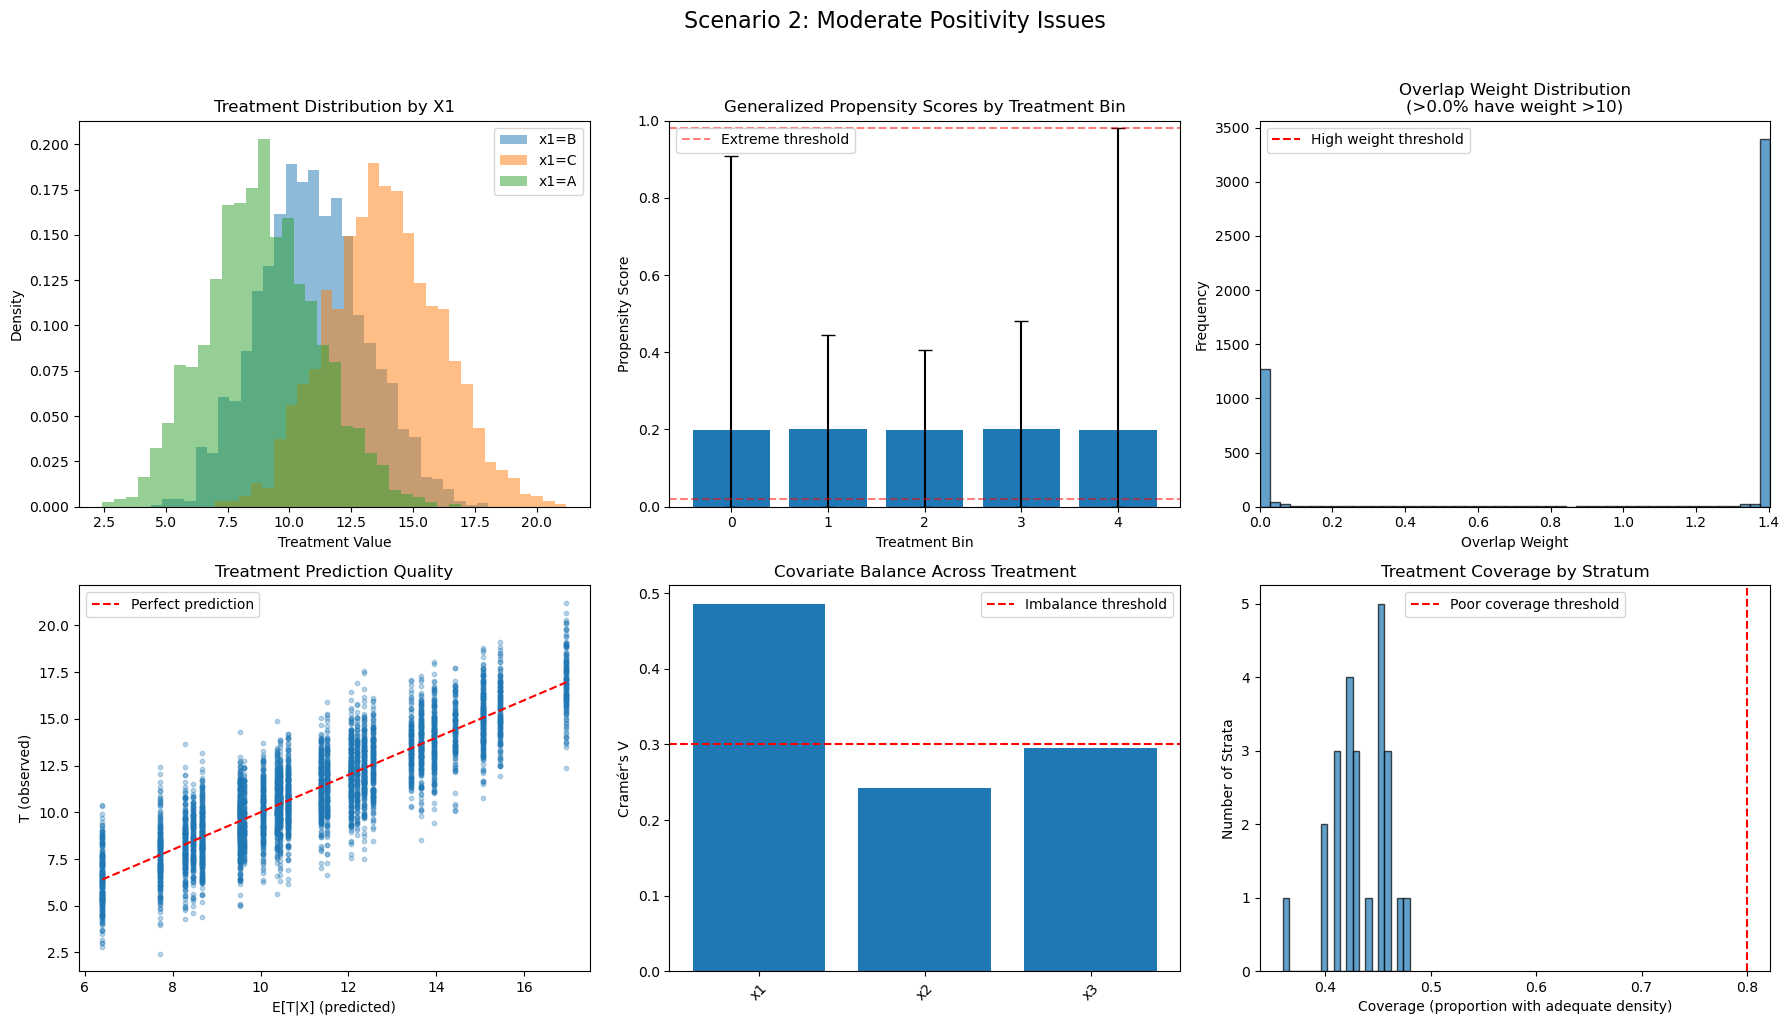


--------------------------------------------------------------------------------
Press Enter to continue to next scenario...

SCENARIO 3: Good Positivity
COMPREHENSIVE POSITIVITY DIAGNOSTICS REPORT

1. STRATUM-SPECIFIC POSITIVITY CHECK
----------------------------------------
Total strata analyzed: 24
Strata with violations: 24

Problematic strata:
           strata  n_units  coverage   min_density
0   (A, K1, high)      160      0.51  7.252364e-17
1    (A, K1, low)      242      0.50  8.893665e-25
2   (A, K2, high)      140      0.46  2.645318e-19
3    (A, K2, low)      224      0.54  5.315808e-10
4   (A, K3, high)      176      0.54  4.826038e-06
5    (A, K3, low)      233      0.53  8.046159e-08
6   (A, K4, high)      142      0.54  1.296288e-11
7    (A, K4, low)      214      0.51  9.448885e-15
8   (B, K1, high)      211      0.52  5.829897e-23
9    (B, K1, low)      279      0.51  1.448461e-09
10  (B, K2, high)      197      0.58  1.417793e-04
11   (B, K2, low)      366      0.52

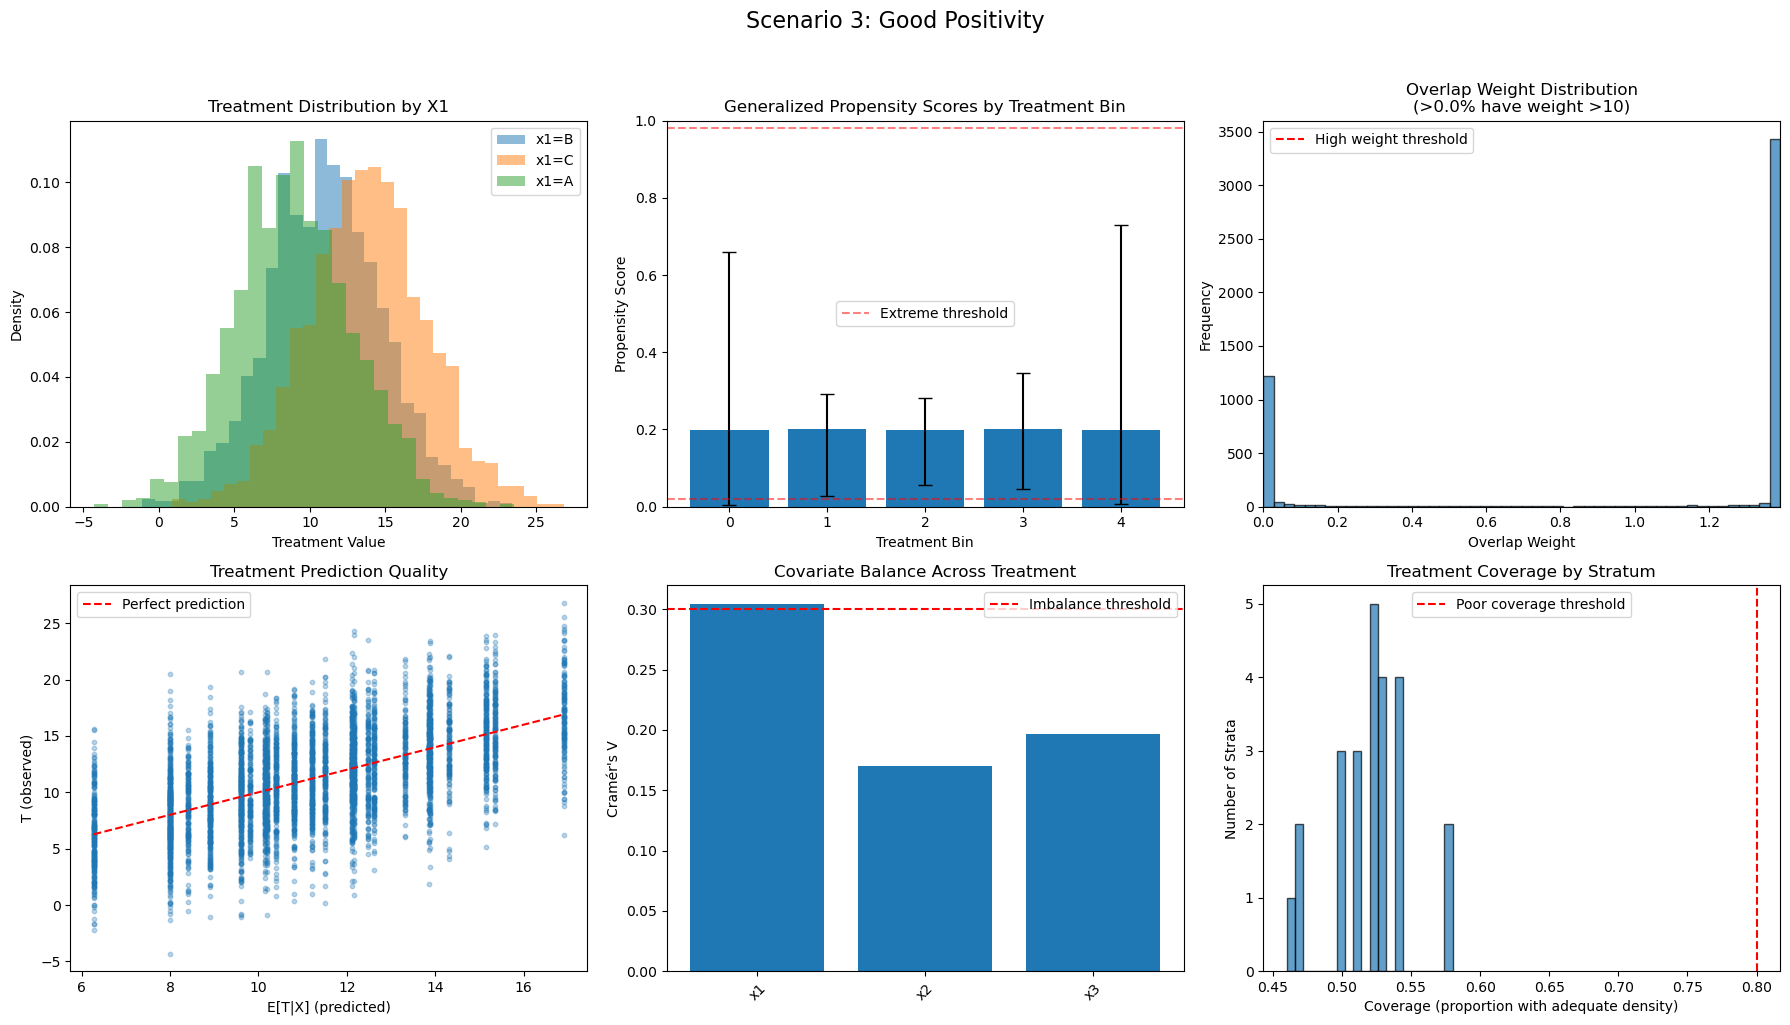


--------------------------------------------------------------------------------
Press Enter to continue to next scenario...

SCENARIO 4: Perfect Randomization
COMPREHENSIVE POSITIVITY DIAGNOSTICS REPORT

1. STRATUM-SPECIFIC POSITIVITY CHECK
----------------------------------------
Total strata analyzed: 24
Strata with violations: 24

Problematic strata:
           strata  n_units  coverage   min_density
0   (A, K1, high)      160      0.67  1.940745e-06
1    (A, K1, low)      242      0.68  2.658556e-05
2   (A, K2, high)      140      0.60  1.255306e-11
3    (A, K2, low)      224      0.74  1.531789e-03
4   (A, K3, high)      176      0.72  9.419205e-04
5    (A, K3, low)      233      0.73  1.381169e-03
6   (A, K4, high)      142      0.72  1.464749e-05
7    (A, K4, low)      214      0.69  7.946237e-05
8   (B, K1, high)      211      0.70  1.618993e-06
9    (B, K1, low)      279      0.68  3.177788e-04
10  (B, K2, high)      197      0.76  2.228956e-03
11   (B, K2, low)      366    

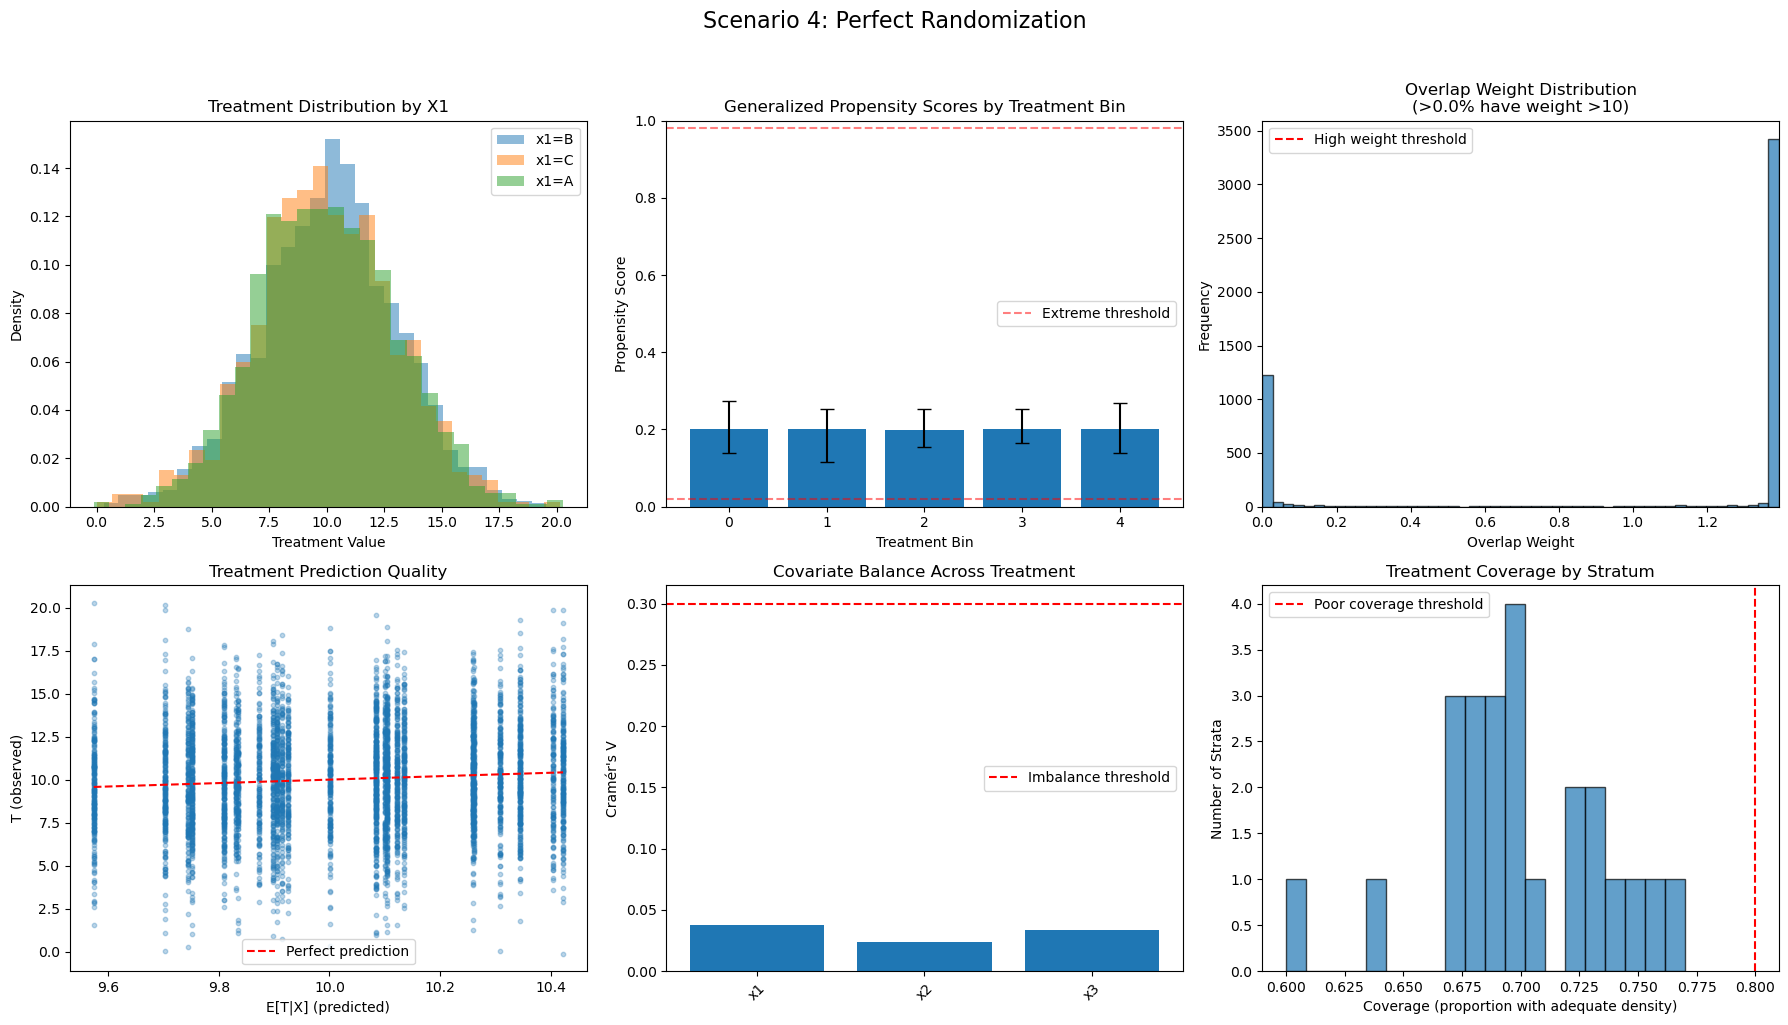


--------------------------------------------------------------------------------
Press Enter to continue to next scenario...

EXAMPLE: Running diagnostics on Scenario 2 with recommendations
COMPREHENSIVE POSITIVITY DIAGNOSTICS REPORT

1. STRATUM-SPECIFIC POSITIVITY CHECK
----------------------------------------
Total strata analyzed: 24
Strata with violations: 24

Problematic strata:
           strata  n_units  coverage    min_density
0   (A, K1, high)       63      0.53   7.492084e-20
1    (A, K1, low)      144      0.44   5.639617e-84
2   (A, K2, high)       98      0.42   2.451113e-29
3    (A, K2, low)      127      0.45   1.821677e-40
4   (A, K3, high)       81      0.49   7.478260e-19
5    (A, K3, low)      164      0.51   2.056649e-18
6   (A, K4, high)       96      0.48   2.615186e-31
7    (A, K4, low)      140      0.43   1.033964e-32
8   (B, K1, high)      105      0.52   1.687803e-09
9    (B, K1, low)      179      0.50   6.305034e-33
10  (B, K2, high)      131      0.48   4

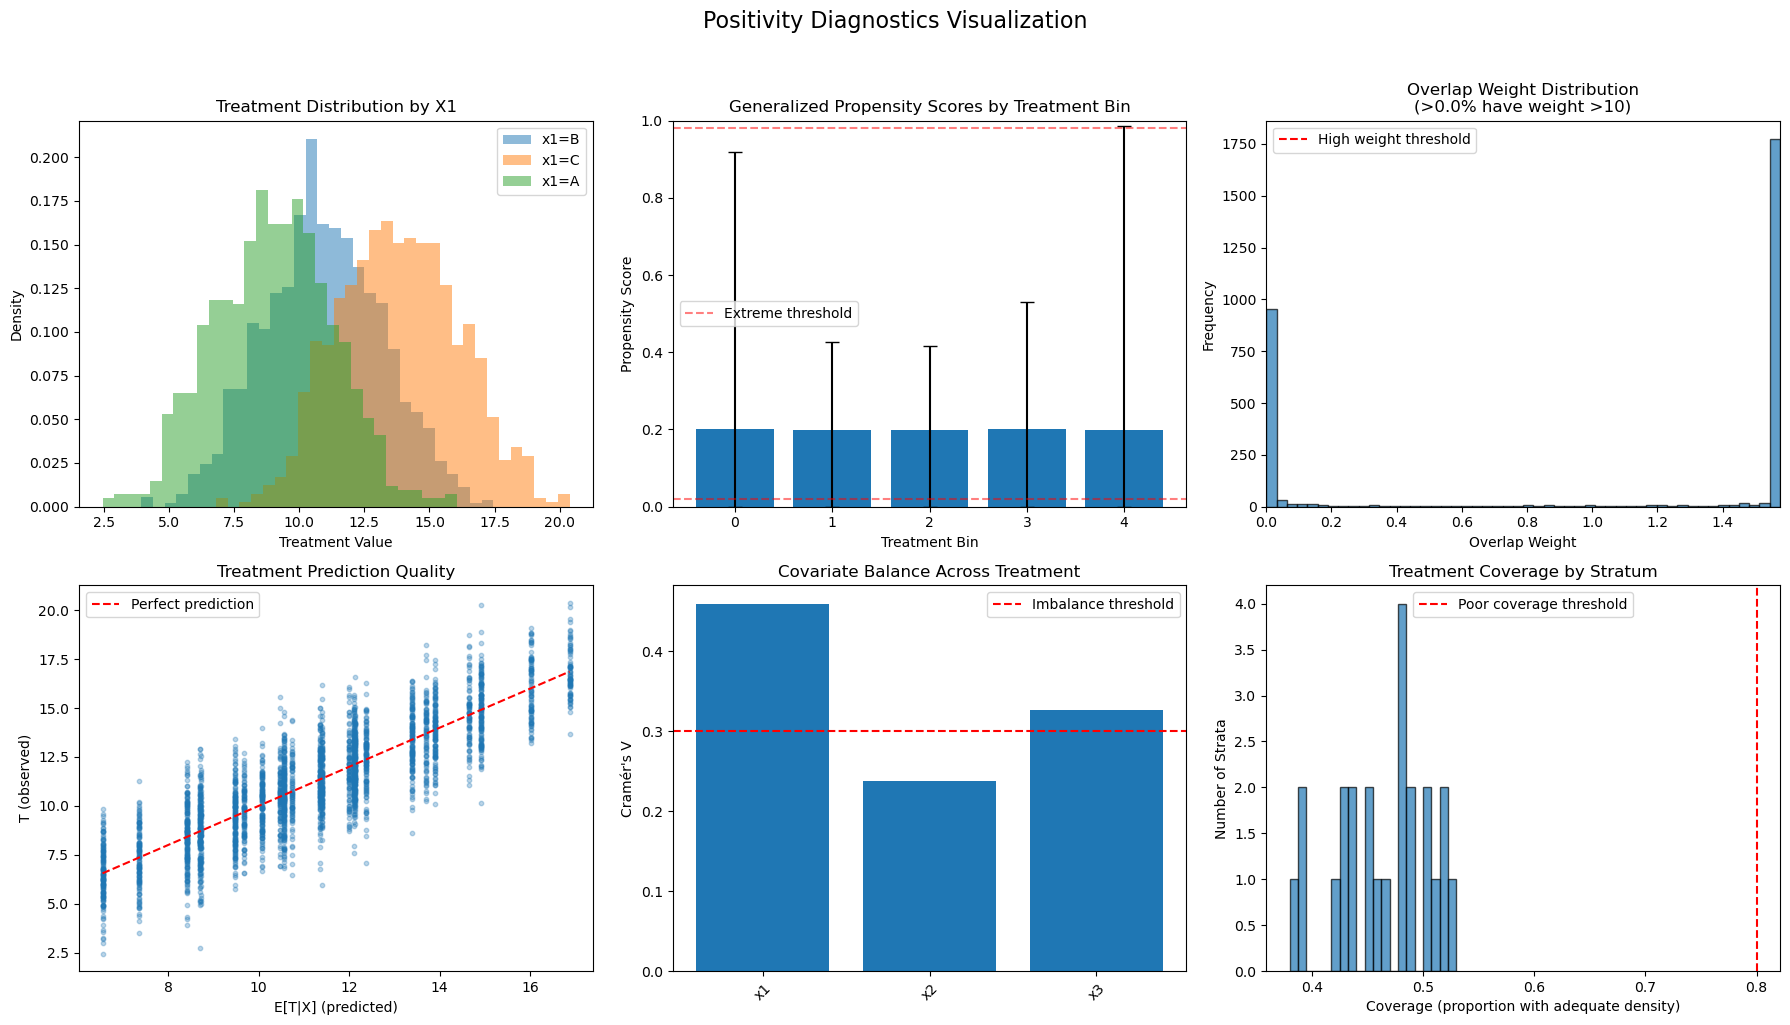

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 1. IMPROVED SIMULATION WITH PROPER SCENARIOS
# ============================================================

def simulate_scenario(n, scenario, seed=42):
    """
    Simulate data with different levels of positivity violations
    
    scenario:
        1 = severe positivity violation (deterministic treatment assignment)
        2 = moderate violation (strong confounding)
        3 = good positivity (moderate confounding with overlap)
        4 = perfect randomization (for comparison)
    """
    np.random.seed(seed)
    
    # Generate confounders
    x1 = np.random.choice(["A", "B", "C"], size=n, p=[0.3, 0.4, 0.3])
    x2 = np.random.choice(["K1", "K2", "K3", "K4"], size=n)
    x3 = np.random.choice(["low", "high"], size=n, p=[0.6, 0.4])
    
    df = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3})
    
    # Base treatment assignment function
    def base_mu(row):
        mu = 5  # baseline
        
        # X1 effects
        if row["x1"] == "A": mu += 1
        if row["x1"] == "B": mu += 3
        if row["x1"] == "C": mu += 6
        
        # X2 effects
        if row["x2"] == "K1": mu += 0.5
        if row["x2"] == "K2": mu += 1.5
        if row["x2"] == "K3": mu += 2.5
        if row["x2"] == "K4": mu += 4
        
        # X3 effects
        if row["x3"] == "high": mu += 2
        
        return mu
    
    mu_arr = df.apply(base_mu, axis=1).values
    
    if scenario == 1:
        # Severe violation: almost deterministic T|X
        # Some covariate combinations almost never get certain treatment values
        noise = np.random.normal(0, 0.3, size=n)
        df["T"] = mu_arr + noise
        
        # Create extreme violation: some strata get truncated treatment
        mask = (df["x1"] == "A") & (df["x3"] == "low")
        df.loc[mask, "T"] = np.clip(df.loc[mask, "T"], None, 7)  # Cap treatment
        
    elif scenario == 2:
        # Moderate violation: strong confounding but some overlap
        noise = np.random.normal(0, 1.5, size=n)
        df["T"] = mu_arr + noise
        
    elif scenario == 3:
        # Good positivity: moderate confounding with good overlap
        noise = np.random.normal(0, 3.5, size=n)
        df["T"] = mu_arr + noise
        
    elif scenario == 4:
        # Perfect randomization (no confounding)
        df["T"] = np.random.normal(10, 3, size=n)
    
    # Add outcome (for completeness, though not used in positivity checks)
    df["Y"] = 2 * df["T"] + np.random.normal(0, 1, size=n)
    
    return df


# ============================================================
# 2. STRATUM-SPECIFIC POSITIVITY CHECK
# ============================================================

def check_stratum_positivity(df, confounders, treatment="T", min_density_threshold=0.01):
    """
    Check if treatment has adequate support within each covariate stratum
    """
    strata_results = []
    
    # Get unique strata
    strata = df.groupby(confounders)
    
    for strata_vals, group in strata:
        if len(group) < 10:  # Skip very small strata
            continue
        
        t_values = group[treatment].values.reshape(-1, 1)
        
        # Fit KDE with optimal bandwidth
        kde = KernelDensity()
        params = {'bandwidth': np.logspace(-1, 1, 20)}
        grid = GridSearchCV(kde, params, cv=3)
        grid.fit(t_values)
        kde_best = grid.best_estimator_
        
        # Evaluate density across treatment range
        t_range = np.linspace(df[treatment].min(), df[treatment].max(), 100).reshape(-1, 1)
        log_density = kde_best.score_samples(t_range)
        density = np.exp(log_density)
        
        # Check for low density regions
        low_density_prop = np.mean(density < min_density_threshold)
        min_density = density.min()
        coverage = 1 - low_density_prop
        
        strata_results.append({
            'strata': strata_vals,
            'n_units': len(group),
            'treatment_mean': t_values.mean(),
            'treatment_std': t_values.std(),
            'min_density': min_density,
            'coverage': coverage,
            'violation': low_density_prop > 0.2  # Flag if >20% has low density
        })
    
    return pd.DataFrame(strata_results)


# ============================================================
# 3. PROPENSITY-BASED DIAGNOSTICS FOR CONTINUOUS TREATMENT
# ============================================================

def generalized_propensity_diagnostics(df, confounders, treatment="T", n_bins=5):
    """
    Discretize continuous treatment and check propensity scores
    """
    # Bin the continuous treatment
    T_binned = pd.qcut(df[treatment], q=n_bins, labels=range(n_bins), duplicates='drop')
    
    # One-hot encode confounders
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X = enc.fit_transform(df[confounders])
    
    diagnostics = []
    propensity_scores = np.zeros((len(df), n_bins))
    
    for t_bin in range(n_bins):
        # Binary indicator for this treatment bin
        y = (T_binned == t_bin).astype(int)
        
        if y.sum() < 10:  # Skip if too few cases
            continue
        
        # Fit propensity model (use RF for flexibility)
        ps_model = RandomForestClassifier(
            n_estimators=100,
            min_samples_leaf=10,
            random_state=42
        )
        ps_model.fit(X, y)
        
        # Get propensity scores
        ps = ps_model.predict_proba(X)
        if ps.shape[1] == 2:
            ps = ps[:, 1]
        else:
            ps = ps[:, 0]  # Handle edge case
        
        propensity_scores[:, t_bin] = ps
        
        # Check for extreme propensities
        extreme_low = np.mean(ps < 0.02)
        extreme_high = np.mean(ps > 0.98)
        
        diagnostics.append({
            'treatment_bin': t_bin,
            'bin_range': f"[{df[treatment][T_binned==t_bin].min():.2f}, {df[treatment][T_binned==t_bin].max():.2f}]",
            'n_units': y.sum(),
            'min_propensity': ps.min(),
            'max_propensity': ps.max(),
            'mean_propensity': ps.mean(),
            'pct_extreme_low': extreme_low,
            'pct_extreme_high': extreme_high,
            'violation': (extreme_low > 0.05) or (extreme_high > 0.05)
        })
    
    return pd.DataFrame(diagnostics), propensity_scores


# ============================================================
# 4. COVARIATE BALANCE ASSESSMENT
# ============================================================

def assess_covariate_balance(df, confounders, treatment="T", n_quantiles=4):
    """
    Check if covariates are balanced across treatment quantiles
    """
    # Create treatment quantiles
    T_quantiles = pd.qcut(df[treatment], q=n_quantiles, labels=[f"Q{i+1}" for i in range(n_quantiles)])
    
    balance_results = []
    
    for col in confounders:
        # Create contingency table
        contingency = pd.crosstab(df[col], T_quantiles)
        
        # Chi-square test
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
        
        # Cramér's V for effect size
        n = contingency.sum().sum()
        min_dim = min(contingency.shape[0] - 1, contingency.shape[1] - 1)
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        balance_results.append({
            'covariate': col,
            'chi2': chi2,
            'p_value': p_value,
            'cramers_v': cramers_v,
            'imbalanced': p_value < 0.001 and cramers_v > 0.3
        })
    
    return pd.DataFrame(balance_results)


# ============================================================
# 5. OVERLAP WEIGHT DIAGNOSTICS
# ============================================================

def calculate_overlap_weights(df, confounders, treatment="T"):
    """
    Calculate overlap weights to assess practical positivity
    """
    # Encode confounders
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X = enc.fit_transform(df[confounders])
    T = df[treatment].values
    
    # Estimate E[T|X] and Var[T|X] using Random Forest
    rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42)
    rf.fit(X, T)
    
    # Get predictions from each tree to estimate variance
    predictions = np.array([tree.predict(X) for tree in rf.estimators_])
    mu_hat = predictions.mean(axis=0)
    sigma2_hat = predictions.var(axis=0) + 1e-6  # Add small constant for stability
    
    # Calculate density under assumed normal distribution
    density = stats.norm.pdf(T, mu_hat, np.sqrt(sigma2_hat))
    
    # Overlap weights (inverse of density)
    weights = 1 / (density + 1e-6)
    weights = np.clip(weights, 0, np.percentile(weights, 99))  # Trim extreme weights
    weights = weights / weights.mean()  # Normalize
    
    return weights, mu_hat, sigma2_hat


# ============================================================
# 6. COMPREHENSIVE POSITIVITY REPORT
# ============================================================

def positivity_report(df, confounders, treatment="T"):
    """
    Generate comprehensive positivity diagnostics report
    """
    print("=" * 80)
    print("COMPREHENSIVE POSITIVITY DIAGNOSTICS REPORT")
    print("=" * 80)
    
    # 1. Stratum-specific checks
    print("\n1. STRATUM-SPECIFIC POSITIVITY CHECK")
    print("-" * 40)
    stratum_df = check_stratum_positivity(df, confounders, treatment)
    violations = stratum_df['violation'].sum()
    print(f"Total strata analyzed: {len(stratum_df)}")
    print(f"Strata with violations: {violations}")
    if violations > 0:
        print("\nProblematic strata:")
        print(stratum_df[stratum_df['violation']][['strata', 'n_units', 'coverage', 'min_density']])
    else:
        print("✅ No stratum-specific violations detected")
    
    # 2. Propensity-based diagnostics
    print("\n2. GENERALIZED PROPENSITY SCORE DIAGNOSTICS")
    print("-" * 40)
    prop_df, ps_scores = generalized_propensity_diagnostics(df, confounders, treatment)
    prop_violations = prop_df['violation'].sum()
    print(f"Treatment bins with extreme propensities: {prop_violations}/{len(prop_df)}")
    if prop_violations > 0:
        print("\nBins with issues:")
        print(prop_df[prop_df['violation']][['treatment_bin', 'bin_range', 'pct_extreme_low', 'pct_extreme_high']])
    else:
        print("✅ No extreme propensity scores detected")
    
    # 3. Covariate balance
    print("\n3. COVARIATE BALANCE ASSESSMENT")
    print("-" * 40)
    balance_df = assess_covariate_balance(df, confounders, treatment)
    imbalances = balance_df['imbalanced'].sum()
    print(f"Imbalanced covariates: {imbalances}/{len(confounders)}")
    if imbalances > 0:
        print("\nImbalanced covariates:")
        print(balance_df[balance_df['imbalanced']][['covariate', 'cramers_v', 'p_value']])
    else:
        print("✅ Covariates are well-balanced across treatment")
    
    # 4. Overlap weights
    print("\n4. OVERLAP WEIGHT DIAGNOSTICS")
    print("-" * 40)
    weights, mu_hat, sigma2_hat = calculate_overlap_weights(df, confounders, treatment)
    print(f"Weight statistics:")
    print(f"  Mean: {weights.mean():.3f}")
    print(f"  Std:  {weights.std():.3f}")
    print(f"  Max:  {weights.max():.3f}")
    print(f"  % with weight > 10: {(weights > 10).mean()*100:.1f}%")
    
    # Overall assessment
    print("\n" + "=" * 80)
    print("OVERALL POSITIVITY ASSESSMENT")
    print("=" * 80)
    
    total_issues = violations + prop_violations + imbalances
    if total_issues == 0:
        print("✅ EXCELLENT: No positivity violations detected")
        print("   → Safe to proceed with causal analysis")
    elif total_issues <= 2:
        print("⚠️  CAUTION: Minor positivity concerns detected")
        print("   → Consider trimming or using overlap weights")
        print("   → Results may have limited generalizability")
    else:
        print("❌ WARNING: Significant positivity violations detected")
        print("   → Causal estimates may be unreliable")
        print("   → Consider restricting analysis to well-supported regions")
        print("   → Use methods robust to positivity violations (e.g., TMLE with truncation)")
    
    return {
        'stratum_df': stratum_df,
        'propensity_df': prop_df,
        'balance_df': balance_df,
        'weights': weights,
        'mu_hat': mu_hat,
        'sigma2_hat': sigma2_hat
    }


# ============================================================
# 7. VISUALIZATION FUNCTIONS
# ============================================================

def plot_positivity_diagnostics(df, results, treatment="T"):
    """
    Create comprehensive visualization of positivity diagnostics
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Positivity Diagnostics Visualization", fontsize=16, y=1.02)
    
    # 1. Treatment distribution by covariate patterns
    ax = axes[0, 0]
    for x1_val in df['x1'].unique():
        subset = df[df['x1'] == x1_val][treatment]
        ax.hist(subset, alpha=0.5, label=f"x1={x1_val}", bins=30, density=True)
    ax.set_xlabel("Treatment Value")
    ax.set_ylabel("Density")
    ax.set_title("Treatment Distribution by X1")
    ax.legend()
    
    # 2. Propensity score distribution
    ax = axes[0, 1]
    prop_df = results['propensity_df']
    x = range(len(prop_df))
    ax.bar(x, prop_df['mean_propensity'], yerr=[
        prop_df['mean_propensity'] - prop_df['min_propensity'],
        prop_df['max_propensity'] - prop_df['mean_propensity']
    ], capsize=5)
    ax.set_xlabel("Treatment Bin")
    ax.set_ylabel("Propensity Score")
    ax.set_title("Generalized Propensity Scores by Treatment Bin")
    ax.axhline(y=0.02, color='r', linestyle='--', alpha=0.5, label='Extreme threshold')
    ax.axhline(y=0.98, color='r', linestyle='--', alpha=0.5)
    ax.set_ylim([0, 1])
    ax.legend()
    
    # 3. Overlap weights distribution
    ax = axes[0, 2]
    weights = results['weights']
    ax.hist(weights, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=10, color='r', linestyle='--', label='High weight threshold')
    ax.set_xlabel("Overlap Weight")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Overlap Weight Distribution\n(>{(weights>10).mean()*100:.1f}% have weight >10)")
    ax.set_xlim([0, min(20, weights.max())])
    ax.legend()
    
    # 4. E[T|X] vs observed T
    ax = axes[1, 0]
    mu_hat = results['mu_hat']
    ax.scatter(mu_hat, df[treatment], alpha=0.3, s=10)
    ax.plot([mu_hat.min(), mu_hat.max()], [mu_hat.min(), mu_hat.max()], 'r--', label='Perfect prediction')
    ax.set_xlabel("E[T|X] (predicted)")
    ax.set_ylabel("T (observed)")
    ax.set_title("Treatment Prediction Quality")
    ax.legend()
    
    # 5. Covariate balance (Cramér's V)
    ax = axes[1, 1]
    balance_df = results['balance_df']
    ax.bar(range(len(balance_df)), balance_df['cramers_v'])
    ax.set_xticks(range(len(balance_df)))
    ax.set_xticklabels(balance_df['covariate'], rotation=45)
    ax.axhline(y=0.3, color='r', linestyle='--', label='Imbalance threshold')
    ax.set_ylabel("Cramér's V")
    ax.set_title("Covariate Balance Across Treatment")
    ax.legend()
    
    # 6. Stratum coverage
    ax = axes[1, 2]
    stratum_df = results['stratum_df']
    if len(stratum_df) > 0:
        coverage = stratum_df['coverage'].values
        ax.hist(coverage, bins=20, edgecolor='black', alpha=0.7)
        ax.axvline(x=0.8, color='r', linestyle='--', label='Poor coverage threshold')
        ax.set_xlabel("Coverage (proportion with adequate density)")
        ax.set_ylabel("Number of Strata")
        ax.set_title("Treatment Coverage by Stratum")
        ax.legend()
    
    plt.tight_layout()
    return fig


# ============================================================
# 8. MAIN EXECUTION
# ============================================================

def main():
    """
    Run complete positivity diagnostics for multiple scenarios
    """
    scenarios = {
        1: "Severe Positivity Violation",
        2: "Moderate Positivity Issues", 
        3: "Good Positivity",
        4: "Perfect Randomization"
    }
    
    for scenario_num, scenario_name in scenarios.items():
        print("\n" + "="*80)
        print(f"SCENARIO {scenario_num}: {scenario_name}")
        print("="*80)
        
        # Generate data
        df = simulate_scenario(n=5000, scenario=scenario_num)
        
        # Run comprehensive diagnostics
        results = positivity_report(df, confounders=["x1", "x2", "x3"], treatment="T")
        
        # Create visualizations
        fig = plot_positivity_diagnostics(df, results, treatment="T")
        plt.suptitle(f"Scenario {scenario_num}: {scenario_name}", fontsize=16, y=1.02)
        plt.show()
        
        print("\n" + "-"*80)
        input("Press Enter to continue to next scenario...")


# ============================================================
# 9. PRACTICAL RECOMMENDATIONS FUNCTION
# ============================================================

def get_recommendations(results):
    """
    Provide actionable recommendations based on diagnostics
    """
    print("\n" + "="*80)
    print("PRACTICAL RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    # Check stratum violations
    stratum_df = results['stratum_df']
    if stratum_df['violation'].sum() > 0:
        recommendations.append(
            "• Stratum trimming: Remove or downweight units in strata with poor treatment support"
        )
        problem_strata = stratum_df[stratum_df['violation']]['strata'].values
        print(f"  Problem strata to consider excluding: {problem_strata}")
    
    # Check propensity issues
    prop_df = results['propensity_df']
    if prop_df['pct_extreme_low'].max() > 0.05:
        recommendations.append(
            "• Propensity trimming: Exclude units with extreme propensity scores (<0.02 or >0.98)"
        )
    
    # Check balance issues
    balance_df = results['balance_df']
    imbalanced = balance_df[balance_df['imbalanced']]['covariate'].values
    if len(imbalanced) > 0:
        recommendations.append(
            f"• Matching or weighting: Focus on balancing {', '.join(imbalanced)}"
        )
    
    # Check overlap weights
    weights = results['weights']
    if (weights > 10).mean() > 0.05:
        recommendations.append(
            "• Use overlap weighting or trimming to handle units with extreme weights"
        )
        recommendations.append(
            "• Consider TMLE or other doubly-robust methods with weight truncation"
        )
    
    if len(recommendations) == 0:
        print("✅ No specific interventions needed - proceed with standard causal analysis")
    else:
        print("Recommended interventions:")
        for rec in recommendations:
            print(rec)
        
        print("\nAlternative approaches to consider:")
        print("• Restrict analysis to region of common support")
        print("• Use machine learning methods that handle positivity violations (e.g., BART, Causal Forests)")
        print("• Report results separately for well-supported and poorly-supported regions")
        print("• Consider sensitivity analysis for positivity violations")
    
    return recommendations


if __name__ == "__main__":
    # Run full diagnostic pipeline
    main()
    
    # Example of running diagnostics on a single dataset
    print("\n" + "="*80)
    print("EXAMPLE: Running diagnostics on Scenario 2 with recommendations")
    print("="*80)
    
    df = simulate_scenario(n=3000, scenario=2)
    results = positivity_report(df, confounders=["x1", "x2", "x3"], treatment="T")
    recommendations = get_recommendations(results)
    
    # Show final visualization
    fig = plot_positivity_diagnostics(df, results, treatment="T")
    plt.show()

HIGH-DIMENSIONAL POSITIVITY DIAGNOSTICS
This script demonstrates improved methods for assessing positivity
when dealing with many confounders (curse of dimensionality)

SCENARIO: GOOD POSITIVITY

Data generated:
  Continuous variables: 5
  Categorical variables: 5
HIGH-DIMENSIONAL POSITIVITY DIAGNOSTICS
Sample size: 2000
Number of confounders: 10
Unique covariate patterns (categorical only): 556
Average units per stratum: 3.60
--------------------------------------------------------------------------------

1. PROPENSITY SCORE STRATIFICATION
----------------------------------------
Number of PS strata: 10
Mean coverage: 0.862
Min coverage: 0.829
✅ Good treatment coverage across PS strata

2. LOCAL NEIGHBORHOOD ANALYSIS
----------------------------------------
Percentage of outliers: 0.0%
Mean local CV: 0.408
✅ Treatment varies smoothly across covariate space

3. TREE-BASED REGION DETECTION
----------------------------------------
✅ No regions with extreme treatment concentration found


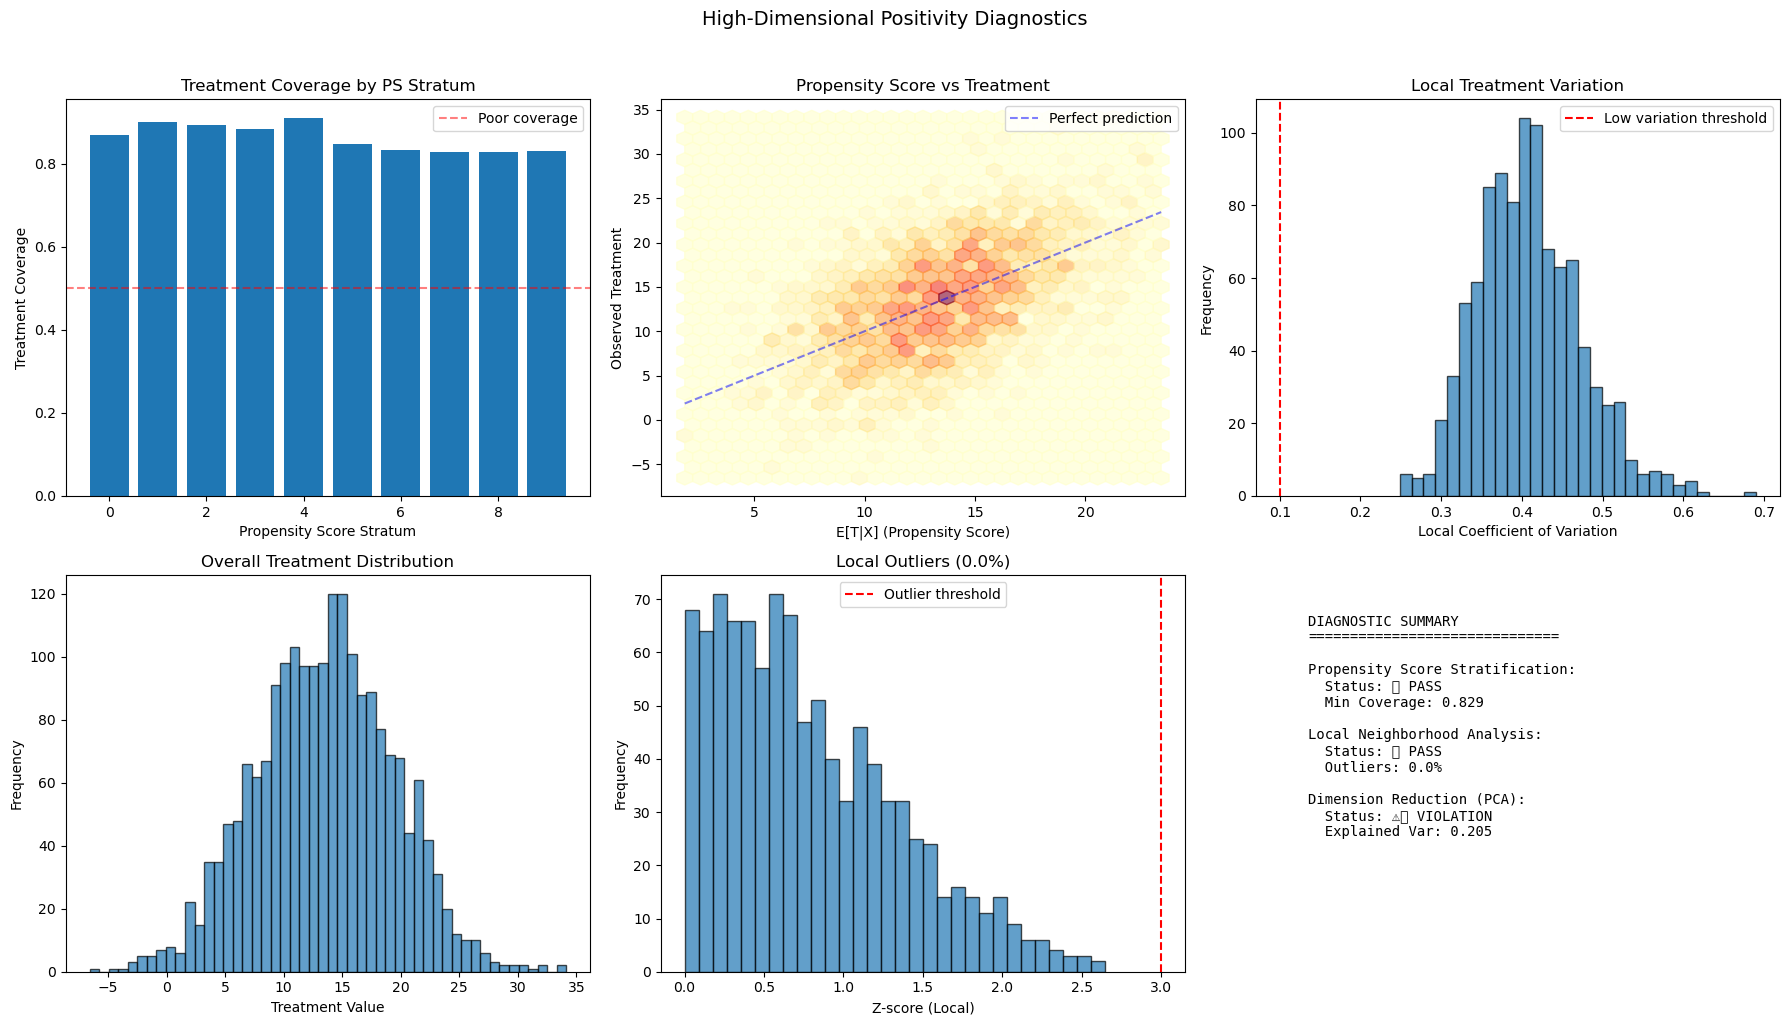


Press Enter to continue to next scenario...

SCENARIO: MODERATE POSITIVITY

Data generated:
  Continuous variables: 5
  Categorical variables: 5
HIGH-DIMENSIONAL POSITIVITY DIAGNOSTICS
Sample size: 2000
Number of confounders: 10
Unique covariate patterns (categorical only): 556
Average units per stratum: 3.60
--------------------------------------------------------------------------------

1. PROPENSITY SCORE STRATIFICATION
----------------------------------------
Number of PS strata: 10
Mean coverage: 0.559
Min coverage: 0.492
✅ Good treatment coverage across PS strata

2. LOCAL NEIGHBORHOOD ANALYSIS
----------------------------------------
Percentage of outliers: 0.0%
Mean local CV: 0.243
✅ Treatment varies smoothly across covariate space

3. TREE-BASED REGION DETECTION
----------------------------------------
⚠️ Found regions with extreme treatment concentration:
  HIGH treatment region: 67 units (3.4%)

4. DIMENSION REDUCTION DIAGNOSTIC
----------------------------------------
Exp

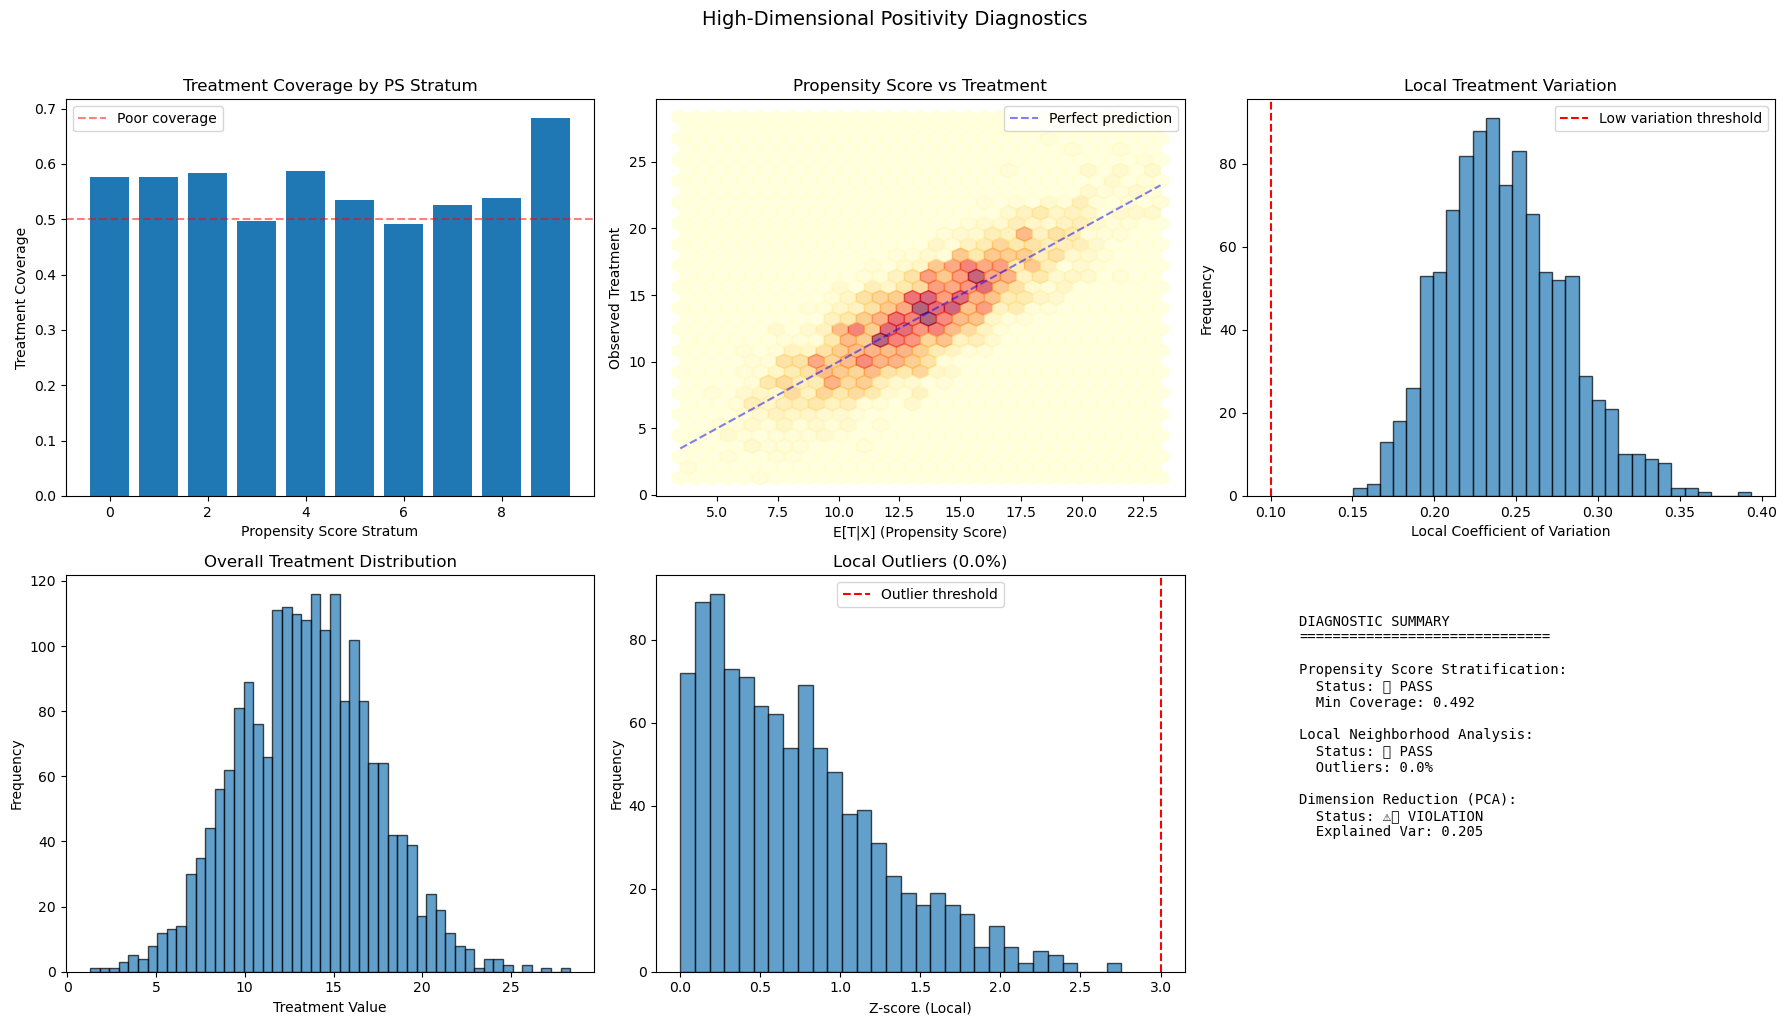


Press Enter to continue to next scenario...

SCENARIO: SEVERE POSITIVITY

Data generated:
  Continuous variables: 5
  Categorical variables: 5
HIGH-DIMENSIONAL POSITIVITY DIAGNOSTICS
Sample size: 2000
Number of confounders: 10
Unique covariate patterns (categorical only): 556
Average units per stratum: 3.60
--------------------------------------------------------------------------------

1. PROPENSITY SCORE STRATIFICATION
----------------------------------------
Number of PS strata: 10
Mean coverage: 0.266
Min coverage: 0.189
⚠️ Violation detected: Some PS strata have poor treatment coverage

2. LOCAL NEIGHBORHOOD ANALYSIS
----------------------------------------
Percentage of outliers: 0.0%
Mean local CV: 0.198
✅ Treatment varies smoothly across covariate space

3. TREE-BASED REGION DETECTION
----------------------------------------
⚠️ Found regions with extreme treatment concentration:
  LOW treatment region: 125 units (6.2%)
  HIGH treatment region: 71 units (3.5%)

4. DIMENSION RE

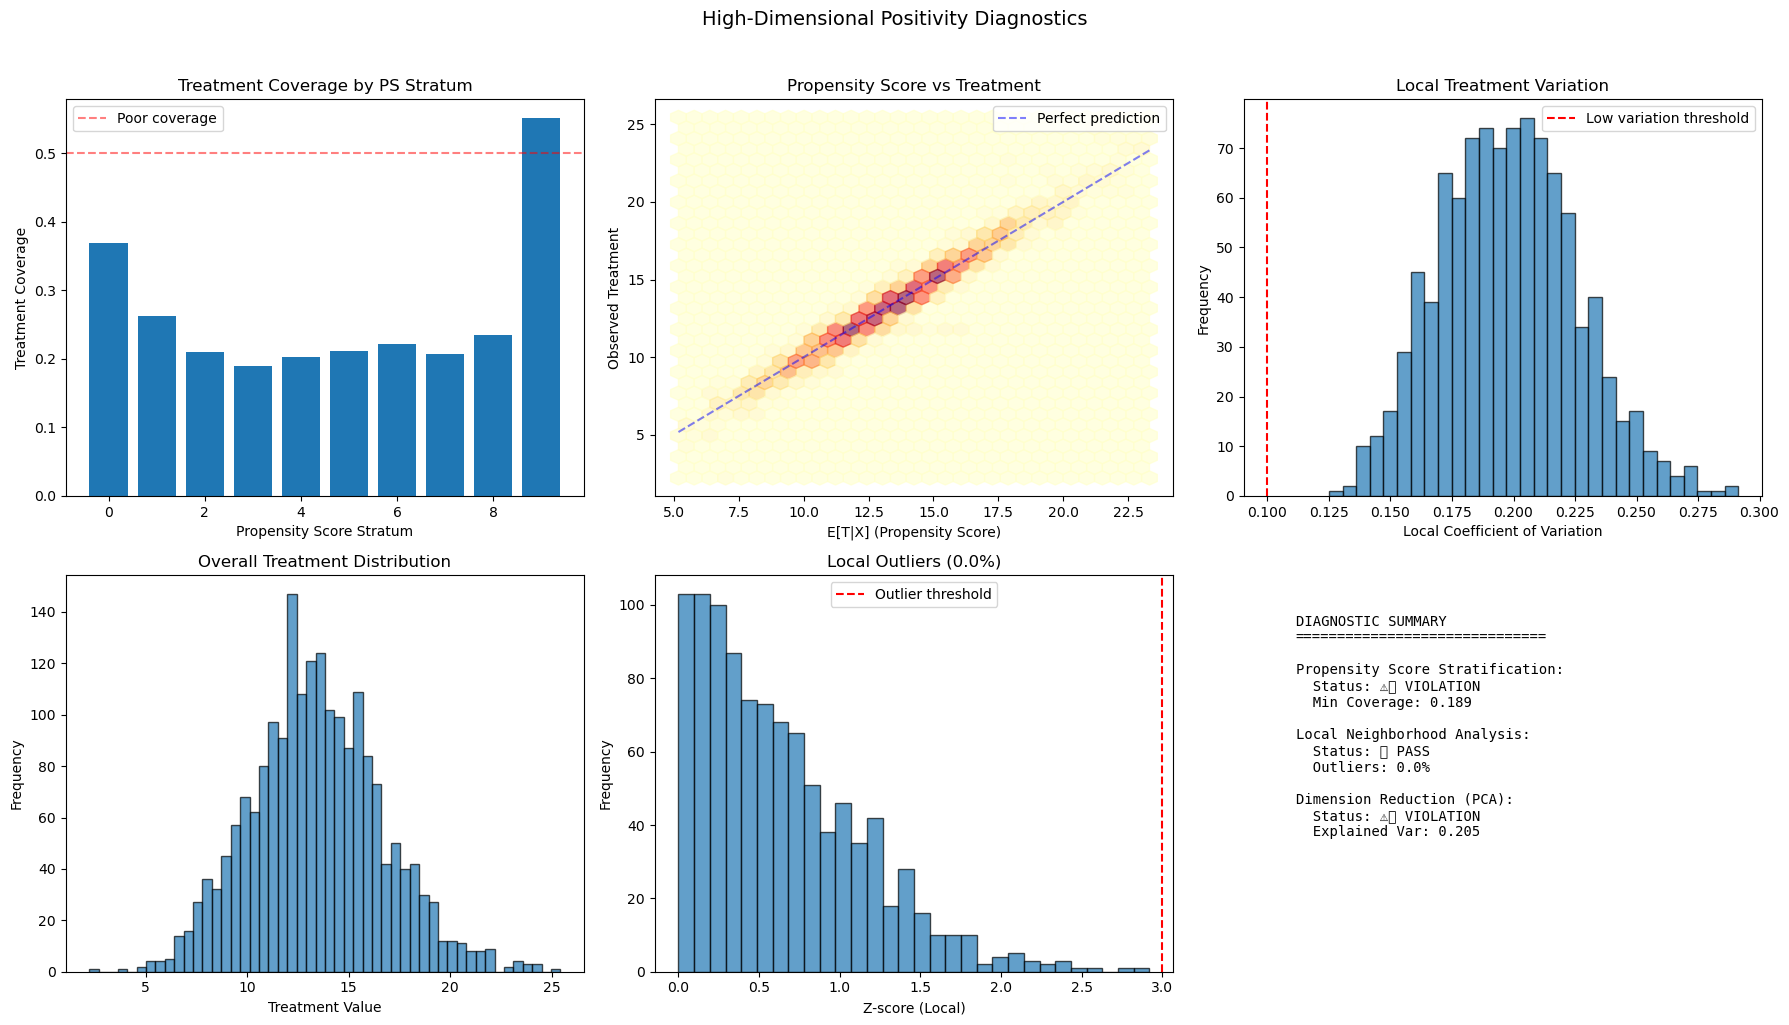


Press Enter to continue to next scenario...


In [11]:
"""
Improved Positivity Diagnostics for High-Dimensional Confounders

This version handles the curse of dimensionality by using:
1. Propensity score stratification instead of covariate stratification
2. Local regression methods for continuous assessments
3. Tree-based region detection for finding problematic areas
4. Dimension reduction techniques
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings('ignore')


# ============================================================
# 1. IMPROVED SIMULATION FOR HIGH-DIMENSIONAL SETTINGS
# ============================================================

def simulate_highdim_data(n=3000, n_continuous=5, n_categorical=5, scenario="moderate"):
    """
    Simulate data with many confounders
    """
    np.random.seed(42)
    
    # Continuous confounders
    X_cont = np.random.randn(n, n_continuous)
    
    # Categorical confounders
    X_cat = []
    cat_names = []
    for i in range(n_categorical):
        levels = np.random.choice([2, 3, 4])  # Random number of levels
        cat_var = np.random.choice(range(levels), size=n)
        X_cat.append(cat_var)
        cat_names.append(f'cat_{i}')
    
    # Create DataFrame
    df = pd.DataFrame(X_cont, columns=[f'cont_{i}' for i in range(n_continuous)])
    for i, name in enumerate(cat_names):
        df[name] = X_cat[i]
    
    # True propensity function (only first few variables matter)
    def true_propensity(row):
        # Main effects from first few variables
        mu = 10
        mu += 2 * row['cont_0']  # Strong effect
        mu += 1.5 * row['cont_1']  # Moderate effect
        mu += 0.5 * row['cont_2']  # Weak effect
        
        # Categorical effects
        if 'cat_0' in row:
            mu += row['cat_0'] * 2
        if 'cat_1' in row:
            mu += row['cat_1'] * 1
        
        # Interaction effect
        mu += 0.5 * row['cont_0'] * row['cont_1']
        
        return mu
    
    mu_true = df.apply(true_propensity, axis=1).values
    
    # Add noise based on scenario
    if scenario == "good":
        noise_sd = 5  # High noise = good overlap
        violations = False
    elif scenario == "moderate":
        noise_sd = 2
        violations = False
    elif scenario == "severe":
        noise_sd = 0.5  # Low noise = poor overlap
        violations = True
    
    treatment = mu_true + np.random.normal(0, noise_sd, n)
    
    # Add violations for severe scenario
    if violations:
        # Create pockets of no support
        mask = (df['cont_0'] > 1.5) & (df['cat_0'] == 0)
        treatment[mask] = np.clip(treatment[mask], None, 12)  # Cap treatment
        
        mask = (df['cont_0'] < -1.5) & (df['cat_0'] == 2)
        treatment[mask] = np.clip(treatment[mask], 8, None)  # Floor treatment
    
    df['treatment'] = treatment
    
    # Add outcome
    df['outcome'] = treatment * 1.5 + np.random.normal(0, 2, n)
    
    return df, mu_true


# ============================================================
# 2. PROPENSITY SCORE-BASED STRATIFICATION
# ============================================================

def propensity_score_stratification(df, confounders, treatment="treatment", n_strata=10):
    """
    Use estimated E[T|X] to create strata, not raw covariates
    This avoids the curse of dimensionality
    """
    # Prepare features
    X = prepare_features(df, confounders)
    T = df[treatment].values
    
    # Estimate E[T|X] using a flexible model with cross-validation
    # This prevents overfitting which would create artificial separation
    model = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=4,
        min_samples_leaf=20,
        subsample=0.8,
        random_state=42
    )
    
    # Use cross-validation predictions to avoid overfitting
    mu_hat = cross_val_predict(model, X, T, cv=5)
    
    # Create strata based on propensity score quantiles
    ps_quantiles = pd.qcut(mu_hat, q=n_strata, labels=False, duplicates='drop')
    n_actual_strata = len(np.unique(ps_quantiles))
    
    # Analyze treatment distribution within each propensity score stratum
    results = []
    for stratum in range(n_actual_strata):
        mask = ps_quantiles == stratum
        T_stratum = T[mask]
        mu_stratum = mu_hat[mask]
        
        if len(T_stratum) < 10:
            continue
        
        # Check overlap within this stratum
        # Key insight: within propensity score strata, we should see overlap
        t_min, t_max = np.percentile(T_stratum, [5, 95])
        t_range = t_max - t_min
        
        # Compare to overall treatment range
        overall_min, overall_max = np.percentile(T, [5, 95])
        overall_range = overall_max - overall_min
        
        coverage = t_range / overall_range if overall_range > 0 else 0
        
        results.append({
            'stratum': stratum,
            'n_units': len(T_stratum),
            'ps_mean': mu_stratum.mean(),
            'ps_range': (mu_stratum.min(), mu_stratum.max()),
            't_mean': T_stratum.mean(),
            't_std': T_stratum.std(),
            't_range': (t_min, t_max),
            'coverage': coverage,
            'cv': T_stratum.std() / T_stratum.mean() if T_stratum.mean() != 0 else 0
        })
    
    results_df = pd.DataFrame(results)
    
    # Calculate overall diagnostic
    mean_coverage = results_df['coverage'].mean()
    min_coverage = results_df['coverage'].min()
    
    diagnostic = {
        'method': 'Propensity Score Stratification',
        'n_strata': n_actual_strata,
        'mean_coverage': mean_coverage,
        'min_coverage': min_coverage,
        'violation': min_coverage < 0.3,  # Flag if any stratum has poor coverage
        'results_df': results_df
    }
    
    return diagnostic, mu_hat, ps_quantiles


# ============================================================
# 3. LOCAL NEIGHBORHOOD ANALYSIS (KNN-BASED)
# ============================================================

def local_neighborhood_diagnostic(df, confounders, treatment="treatment", n_neighbors=50):
    """
    For each unit, check treatment variation in its local neighborhood
    This avoids explicit stratification
    """
    X = prepare_features(df, confounders)
    T = df[treatment].values
    
    # Standardize features for distance calculation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find neighbors for each point
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    nbrs.fit(X_scaled)
    
    # For each point, analyze treatment distribution in neighborhood
    local_diagnostics = []
    
    # Sample points to evaluate (for computational efficiency)
    n_eval = min(1000, len(df))
    eval_indices = np.random.choice(len(df), n_eval, replace=False)
    
    for idx in eval_indices:
        # Find neighbors
        distances, indices = nbrs.kneighbors([X_scaled[idx]])
        neighbor_treatments = T[indices[0]]
        
        # Calculate local statistics
        local_mean = neighbor_treatments.mean()
        local_std = neighbor_treatments.std()
        local_cv = local_std / local_mean if local_mean != 0 else 0
        
        # Check if current treatment is an outlier in its neighborhood
        z_score = abs(T[idx] - local_mean) / (local_std + 1e-6)
        
        local_diagnostics.append({
            'unit': idx,
            'treatment': T[idx],
            'local_mean': local_mean,
            'local_std': local_std,
            'local_cv': local_cv,
            'z_score': z_score,
            'is_outlier': z_score > 3
        })
    
    diag_df = pd.DataFrame(local_diagnostics)
    
    # Summary statistics
    pct_outliers = diag_df['is_outlier'].mean()
    mean_cv = diag_df['local_cv'].mean()
    
    diagnostic = {
        'method': 'Local Neighborhood Analysis',
        'n_neighbors': n_neighbors,
        'pct_outliers': pct_outliers,
        'mean_local_cv': mean_cv,
        'violation': pct_outliers > 0.05 or mean_cv < 0.1,
        'details': diag_df
    }
    
    return diagnostic


# ============================================================
# 4. TREE-BASED REGION DETECTION
# ============================================================

def tree_based_region_detection(df, confounders, treatment="treatment", 
                                min_samples_leaf=50, max_depth=5):
    """
    Use decision trees to find regions with extreme treatment values
    This automatically finds problematic covariate combinations
    """
    X = prepare_features(df, confounders)
    T = df[treatment].values
    
    # Fit trees to find regions with extreme high/low treatments
    results = {}
    
    for extreme in ['low', 'high']:
        if extreme == 'low':
            # Find regions with very low treatment
            threshold = np.percentile(T, 10)
            y = (T < threshold).astype(int)
        else:
            # Find regions with very high treatment
            threshold = np.percentile(T, 90)
            y = (T > threshold).astype(int)
        
        # Fit tree to identify these regions
        tree = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        tree.fit(X, y)
        
        # Get predictions (probability of extreme treatment)
        prob_extreme = tree.predict(X)
        
        # Identify problematic regions (high probability of extreme)
        problematic = prob_extreme > 0.7
        
        if problematic.sum() > 0:
            # Characterize problematic regions
            problem_df = df[problematic].copy()
            problem_df['prob_extreme'] = prob_extreme[problematic]
            
            results[extreme] = {
                'n_units': problematic.sum(),
                'pct_units': problematic.mean(),
                'threshold': threshold,
                'mean_treatment': T[problematic].mean(),
                'std_treatment': T[problematic].std()
            }
    
    # Calculate diagnostic
    has_violations = len(results) > 0
    
    diagnostic = {
        'method': 'Tree-based Region Detection',
        'violations_found': has_violations,
        'extreme_regions': results
    }
    
    return diagnostic, tree if has_violations else None


# ============================================================
# 5. DIMENSION REDUCTION DIAGNOSTIC
# ============================================================

def dimension_reduction_diagnostic(df, confounders, treatment="treatment", n_components=3):
    """
    Use PCA to reduce dimensionality, then check positivity in lower-dimensional space
    """
    X = prepare_features(df, confounders)
    T = df[treatment].values
    
    # Standardize before PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Explained variance
    explained_var = pca.explained_variance_ratio_.sum()
    
    # Create grid in PCA space and check treatment support
    grid_resolution = 10
    grid_points = []
    
    for dim in range(n_components):
        dim_min, dim_max = X_pca[:, dim].min(), X_pca[:, dim].max()
        grid_points.append(np.linspace(dim_min, dim_max, grid_resolution))
    
    # For 2D/3D PCA space, we can check coverage more thoroughly
    if n_components <= 3:
        # Find empty regions in PCA space
        from scipy.spatial import KDTree
        tree = KDTree(X_pca)
        
        # Sample grid points
        if n_components == 2:
            xx, yy = np.meshgrid(grid_points[0], grid_points[1])
            test_points = np.c_[xx.ravel(), yy.ravel()]
        else:  # n_components == 3
            test_points = []
            for i in range(grid_resolution):
                for j in range(grid_resolution):
                    for k in range(grid_resolution):
                        test_points.append([grid_points[0][i], 
                                          grid_points[1][j], 
                                          grid_points[2][k]])
            test_points = np.array(test_points)
        
        # Check density around each grid point
        distances, _ = tree.query(test_points, k=10)
        mean_distances = distances.mean(axis=1)
        
        # Points with large distances have low data density
        empty_regions = mean_distances > np.percentile(mean_distances, 90)
        pct_empty = empty_regions.mean()
    else:
        pct_empty = None
    
    diagnostic = {
        'method': 'Dimension Reduction (PCA)',
        'n_components': n_components,
        'explained_variance': explained_var,
        'pct_empty_regions': pct_empty,
        'violation': explained_var < 0.5 or (pct_empty is not None and pct_empty > 0.3)
    }
    
    return diagnostic, X_pca


# ============================================================
# 6. HELPER FUNCTIONS
# ============================================================

def prepare_features(df, confounders):
    """
    Prepare features matrix from mixed continuous/categorical variables
    """
    continuous_vars = [c for c in confounders if 'cont' in c or df[c].dtype in ['float64', 'int64']]
    categorical_vars = [c for c in confounders if c not in continuous_vars]
    
    features = []
    
    # Add continuous variables
    if continuous_vars:
        features.append(df[continuous_vars].values)
    
    # One-hot encode categorical variables
    if categorical_vars:
        enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        cat_encoded = enc.fit_transform(df[categorical_vars])
        features.append(cat_encoded)
    
    # Combine features
    if features:
        X = np.hstack(features) if len(features) > 1 else features[0]
    else:
        X = np.empty((len(df), 0))
    
    return X


# ============================================================
# 7. COMPREHENSIVE HIGH-DIM DIAGNOSTIC
# ============================================================

def highdim_positivity_diagnostic(df, confounders, treatment="treatment"):
    """
    Run comprehensive positivity diagnostics for high-dimensional confounders
    """
    print("=" * 80)
    print("HIGH-DIMENSIONAL POSITIVITY DIAGNOSTICS")
    print("=" * 80)
    print(f"Sample size: {len(df)}")
    print(f"Number of confounders: {len(confounders)}")
    
    # Count actual unique strata (for comparison)
    categorical_vars = [c for c in confounders if 'cat' in str(c)]
    if categorical_vars and len(categorical_vars) <= 5:
        unique_strata = df[categorical_vars].drop_duplicates()
        print(f"Unique covariate patterns (categorical only): {len(unique_strata)}")
        print(f"Average units per stratum: {len(df)/len(unique_strata):.2f}")
    
    print("-" * 80)
    
    all_diagnostics = {}
    
    # 1. Propensity Score Stratification
    print("\n1. PROPENSITY SCORE STRATIFICATION")
    print("-" * 40)
    ps_diagnostic, mu_hat, ps_strata = propensity_score_stratification(
        df, confounders, treatment
    )
    all_diagnostics['propensity'] = ps_diagnostic
    
    print(f"Number of PS strata: {ps_diagnostic['n_strata']}")
    print(f"Mean coverage: {ps_diagnostic['mean_coverage']:.3f}")
    print(f"Min coverage: {ps_diagnostic['min_coverage']:.3f}")
    if ps_diagnostic['violation']:
        print("⚠️ Violation detected: Some PS strata have poor treatment coverage")
    else:
        print("✅ Good treatment coverage across PS strata")
    
    # 2. Local Neighborhood Analysis
    print("\n2. LOCAL NEIGHBORHOOD ANALYSIS")
    print("-" * 40)
    local_diagnostic = local_neighborhood_diagnostic(df, confounders, treatment)
    all_diagnostics['local'] = local_diagnostic
    
    print(f"Percentage of outliers: {local_diagnostic['pct_outliers']*100:.1f}%")
    print(f"Mean local CV: {local_diagnostic['mean_local_cv']:.3f}")
    if local_diagnostic['violation']:
        print("⚠️ Violation detected: Many units have unusual treatments for their neighborhood")
    else:
        print("✅ Treatment varies smoothly across covariate space")
    
    # 3. Tree-based Region Detection
    print("\n3. TREE-BASED REGION DETECTION")
    print("-" * 40)
    tree_diagnostic, problem_tree = tree_based_region_detection(df, confounders, treatment)
    all_diagnostics['tree'] = tree_diagnostic
    
    if tree_diagnostic['violations_found']:
        print("⚠️ Found regions with extreme treatment concentration:")
        for extreme, info in tree_diagnostic['extreme_regions'].items():
            print(f"  {extreme.upper()} treatment region: {info['n_units']} units ({info['pct_units']*100:.1f}%)")
    else:
        print("✅ No regions with extreme treatment concentration found")
    
    # 4. Dimension Reduction
    print("\n4. DIMENSION REDUCTION DIAGNOSTIC")
    print("-" * 40)
    pca_diagnostic, X_pca = dimension_reduction_diagnostic(df, confounders, treatment)
    all_diagnostics['pca'] = pca_diagnostic
    
    print(f"Explained variance (3 PCs): {pca_diagnostic['explained_variance']:.3f}")
    if pca_diagnostic['pct_empty_regions'] is not None:
        print(f"Empty regions in PCA space: {pca_diagnostic['pct_empty_regions']*100:.1f}%")
    if pca_diagnostic['violation']:
        print("⚠️ Low dimensional structure suggests potential positivity issues")
    else:
        print("✅ Good coverage in reduced dimensional space")
    
    # Overall Assessment
    print("\n" + "=" * 80)
    print("OVERALL ASSESSMENT")
    print("=" * 80)
    
    violations = sum(d['violation'] for d in all_diagnostics.values() if 'violation' in d)
    
    if violations == 0:
        print("✅ EXCELLENT: No positivity violations detected")
        print("   → Safe to proceed with causal analysis")
    elif violations <= 1:
        print("⚠️ CAUTION: Minor positivity concerns detected")
        print("   → Consider using robust methods (e.g., doubly robust estimators)")
        print("   → Check sensitivity to model specification")
    else:
        print("❌ WARNING: Multiple positivity violations detected")
        print("   → Consider dimension reduction before analysis")
        print("   → Use methods that handle limited overlap (e.g., BART, Causal Forests)")
        print("   → Report limitations and conduct sensitivity analyses")
    
    return all_diagnostics, mu_hat


# ============================================================
# 8. VISUALIZATION FOR HIGH-DIM DIAGNOSTICS
# ============================================================

def plot_highdim_diagnostics(df, diagnostics, mu_hat, treatment="treatment"):
    """
    Visualize high-dimensional positivity diagnostics
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    T = df[treatment].values
    
    # 1. Propensity Score Stratification
    ax = axes[0, 0]
    ps_df = diagnostics['propensity']['results_df']
    x = range(len(ps_df))
    ax.bar(x, ps_df['coverage'])
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Poor coverage')
    ax.set_xlabel("Propensity Score Stratum")
    ax.set_ylabel("Treatment Coverage")
    ax.set_title("Treatment Coverage by PS Stratum")
    ax.legend()
    
    # 2. E[T|X] vs Observed T
    ax = axes[0, 1]
    ax.hexbin(mu_hat, T, gridsize=30, cmap='YlOrRd', alpha=0.6)
    ax.plot([mu_hat.min(), mu_hat.max()], [mu_hat.min(), mu_hat.max()], 
            'b--', alpha=0.5, label='Perfect prediction')
    ax.set_xlabel("E[T|X] (Propensity Score)")
    ax.set_ylabel("Observed Treatment")
    ax.set_title("Propensity Score vs Treatment")
    ax.legend()
    
    # 3. Local CV Distribution
    ax = axes[0, 2]
    local_df = diagnostics['local']['details']
    ax.hist(local_df['local_cv'], bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(x=0.1, color='r', linestyle='--', label='Low variation threshold')
    ax.set_xlabel("Local Coefficient of Variation")
    ax.set_ylabel("Frequency")
    ax.set_title("Local Treatment Variation")
    ax.legend()
    
    # 4. Treatment Distribution
    ax = axes[1, 0]
    ax.hist(T, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel("Treatment Value")
    ax.set_ylabel("Frequency")
    ax.set_title("Overall Treatment Distribution")
    
    # 5. Z-score Distribution (Local Outliers)
    ax = axes[1, 1]
    ax.hist(local_df['z_score'], bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(x=3, color='r', linestyle='--', label='Outlier threshold')
    ax.set_xlabel("Z-score (Local)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Local Outliers ({(local_df['z_score']>3).mean()*100:.1f}%)")
    ax.legend()
    
    # 6. Summary Text
    ax = axes[1, 2]
    ax.axis('off')
    
    summary_text = "DIAGNOSTIC SUMMARY\n" + "="*30 + "\n\n"
    
    for method, diag in diagnostics.items():
        if 'violation' in diag:
            status = "⚠️ VIOLATION" if diag['violation'] else "✅ PASS"
            summary_text += f"{diag['method']}:\n  Status: {status}\n"
            
            if method == 'propensity':
                summary_text += f"  Min Coverage: {diag['min_coverage']:.3f}\n"
            elif method == 'local':
                summary_text += f"  Outliers: {diag['pct_outliers']*100:.1f}%\n"
            elif method == 'tree' and diag['violations_found']:
                summary_text += f"  Extreme regions found\n"
            elif method == 'pca':
                summary_text += f"  Explained Var: {diag['explained_variance']:.3f}\n"
            
            summary_text += "\n"
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.suptitle("High-Dimensional Positivity Diagnostics", fontsize=14, y=1.02)
    plt.tight_layout()
    
    return fig


# ============================================================
# 9. RECOMMENDATIONS FOR HIGH-DIM SETTINGS
# ============================================================

def get_highdim_recommendations(diagnostics):
    """
    Provide specific recommendations for high-dimensional settings
    """
    print("\n" + "=" * 80)
    print("RECOMMENDATIONS FOR HIGH-DIMENSIONAL ANALYSIS")
    print("=" * 80)
    
    recommendations = []
    
    # Check each diagnostic
    if diagnostics['propensity']['violation']:
        recommendations.append(
            "• Use propensity score weighting or matching instead of covariate adjustment"
        )
        recommendations.append(
            "• Consider trimming units in extreme PS strata"
        )
    
    if diagnostics['local']['violation']:
        recommendations.append(
            "• Use local methods (e.g., matching with calipers, kernel weighting)"
        )
        recommendations.append(
            "• Consider BART or Causal Forests that handle local sparsity well"
        )
    
    if diagnostics['tree']['violations_found']:
        recommendations.append(
            "• Investigate specific covariate combinations causing violations"
        )
        recommendations.append(
            "• Consider separate analyses for different regions"
        )
    
    if diagnostics['pca']['violation']:
        recommendations.append(
            "• Consider dimension reduction before causal analysis"
        )
        recommendations.append(
            "• Use variable selection to focus on important confounders"
        )
    
    if len(recommendations) == 0:
        print("✅ No specific interventions needed despite high dimensionality")
    else:
        print("Recommended approaches:")
        for rec in recommendations:
            print(rec)
    
    print("\nGeneral strategies for high-dimensional confounders:")
    print("• Use doubly robust methods (AIPW, TMLE) for additional protection")
    print("• Consider Lasso or Random Forest for variable selection")
    print("• Use cross-validation to prevent overfitting in propensity models")
    print("• Report sensitivity to different model specifications")
    print("• Consider targeted learning approaches that focus on the estimand")
    
    return recommendations


# ============================================================
# 10. EXAMPLE USAGE
# ============================================================

def example_highdim_analysis():
    """
    Demonstrate the improved diagnostics on high-dimensional data
    """
    scenarios = ["good", "moderate", "severe"]
    
    for scenario in scenarios:
        print("\n" + "="*80)
        print(f"SCENARIO: {scenario.upper()} POSITIVITY")
        print("="*80)
        
        # Generate high-dimensional data
        df, mu_true = simulate_highdim_data(
            n=2000,
            n_continuous=5,
            n_categorical=5,
            scenario=scenario
        )
        
        # Get confounders
        confounders = [col for col in df.columns if col not in ['treatment', 'outcome']]
        
        print(f"\nData generated:")
        print(f"  Continuous variables: {sum('cont' in c for c in confounders)}")
        print(f"  Categorical variables: {sum('cat' in c for c in confounders)}")
        
        # Run diagnostics
        diagnostics, mu_hat = highdim_positivity_diagnostic(df, confounders, "treatment")
        
        # Get recommendations
        recommendations = get_highdim_recommendations(diagnostics)
        
        # Visualize
        fig = plot_highdim_diagnostics(df, diagnostics, mu_hat, "treatment")
        plt.show()
        
        input("\nPress Enter to continue to next scenario...")


if __name__ == "__main__":
    print("HIGH-DIMENSIONAL POSITIVITY DIAGNOSTICS")
    print("=" * 80)
    print("This script demonstrates improved methods for assessing positivity")
    print("when dealing with many confounders (curse of dimensionality)")
    print("=" * 80)
    
    example_highdim_analysis()